# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

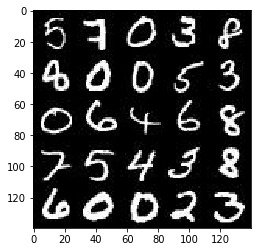

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

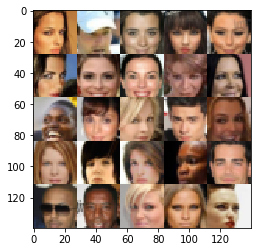

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/w/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_height,image_width,image_channels),name="input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name="input_z")
    learning_rate_pl =tf.placeholder(tf.float32,name="learning_rate")
    return input_real,input_z,learning_rate_pl


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.20
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2,  training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3,  training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        flat  = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(
             logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
                  learning_rate, beta1=beta1).minimize(
                  d_loss, var_list=d_vars)
    with tf.control_dependencies(
         tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(
                      learning_rate, beta1=beta1).minimize(
                      g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2... Discriminator Loss: 2.2931... Generator Loss: 6.8690
Epoch 0/2... Discriminator Loss: 0.4990... Generator Loss: 10.4361
Epoch 0/2... Discriminator Loss: 1.3124... Generator Loss: 0.7036
Epoch 0/2... Discriminator Loss: 0.7993... Generator Loss: 1.5204


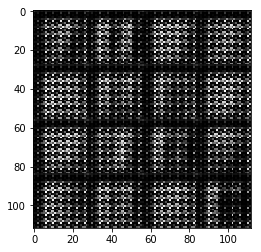

Epoch 0/2... Discriminator Loss: 1.4285... Generator Loss: 4.1412
Epoch 0/2... Discriminator Loss: 1.3680... Generator Loss: 4.3015
Epoch 0/2... Discriminator Loss: 2.4658... Generator Loss: 0.2614
Epoch 0/2... Discriminator Loss: 1.3140... Generator Loss: 0.7097
Epoch 0/2... Discriminator Loss: 1.2562... Generator Loss: 1.0975


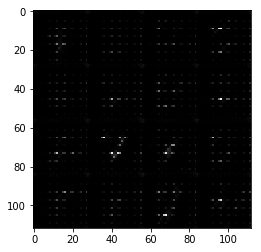

Epoch 0/2... Discriminator Loss: 1.3201... Generator Loss: 0.8858
Epoch 0/2... Discriminator Loss: 1.7191... Generator Loss: 1.9564
Epoch 0/2... Discriminator Loss: 1.5507... Generator Loss: 0.9057
Epoch 0/2... Discriminator Loss: 1.3744... Generator Loss: 1.6442
Epoch 0/2... Discriminator Loss: 1.1786... Generator Loss: 1.0245


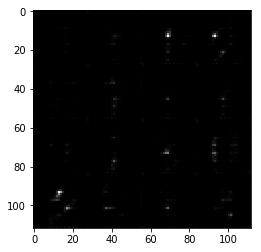

Epoch 0/2... Discriminator Loss: 1.6919... Generator Loss: 0.5121
Epoch 0/2... Discriminator Loss: 2.1213... Generator Loss: 2.0932
Epoch 0/2... Discriminator Loss: 1.2166... Generator Loss: 1.8309
Epoch 0/2... Discriminator Loss: 1.1676... Generator Loss: 0.8997
Epoch 0/2... Discriminator Loss: 1.3958... Generator Loss: 1.5804


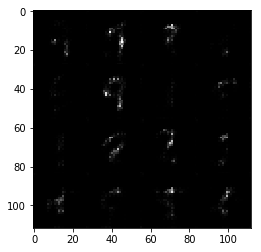

Epoch 0/2... Discriminator Loss: 1.8825... Generator Loss: 1.0537
Epoch 0/2... Discriminator Loss: 1.3121... Generator Loss: 1.8544
Epoch 0/2... Discriminator Loss: 1.6569... Generator Loss: 1.5679
Epoch 0/2... Discriminator Loss: 1.3981... Generator Loss: 0.7155
Epoch 0/2... Discriminator Loss: 1.2119... Generator Loss: 1.1092


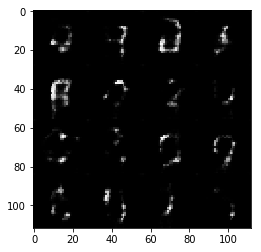

Epoch 0/2... Discriminator Loss: 1.4361... Generator Loss: 1.1936
Epoch 0/2... Discriminator Loss: 1.2488... Generator Loss: 1.7055
Epoch 0/2... Discriminator Loss: 1.2020... Generator Loss: 0.8895
Epoch 0/2... Discriminator Loss: 1.6159... Generator Loss: 0.4243
Epoch 0/2... Discriminator Loss: 1.4033... Generator Loss: 0.5023


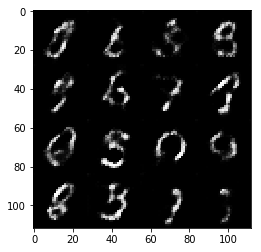

Epoch 0/2... Discriminator Loss: 1.4768... Generator Loss: 1.0772
Epoch 0/2... Discriminator Loss: 1.6236... Generator Loss: 0.5594
Epoch 0/2... Discriminator Loss: 1.1249... Generator Loss: 0.9504
Epoch 0/2... Discriminator Loss: 1.5536... Generator Loss: 1.1873
Epoch 0/2... Discriminator Loss: 1.1834... Generator Loss: 1.4477


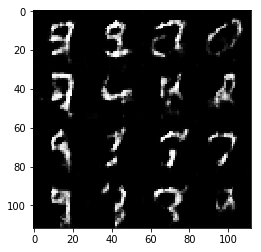

Epoch 0/2... Discriminator Loss: 1.4946... Generator Loss: 0.5612
Epoch 0/2... Discriminator Loss: 1.4880... Generator Loss: 1.6581
Epoch 0/2... Discriminator Loss: 1.4444... Generator Loss: 1.5953
Epoch 0/2... Discriminator Loss: 1.1932... Generator Loss: 1.0754
Epoch 0/2... Discriminator Loss: 1.4951... Generator Loss: 0.5990


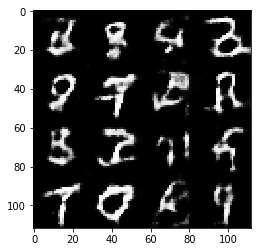

Epoch 0/2... Discriminator Loss: 1.1804... Generator Loss: 1.0444
Epoch 0/2... Discriminator Loss: 1.4153... Generator Loss: 0.6729
Epoch 0/2... Discriminator Loss: 1.4956... Generator Loss: 0.4820
Epoch 0/2... Discriminator Loss: 1.1822... Generator Loss: 0.9201
Epoch 0/2... Discriminator Loss: 1.5091... Generator Loss: 1.4359


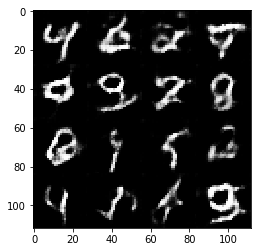

Epoch 0/2... Discriminator Loss: 1.2357... Generator Loss: 0.7881
Epoch 0/2... Discriminator Loss: 1.3202... Generator Loss: 1.1165
Epoch 0/2... Discriminator Loss: 1.2755... Generator Loss: 0.6721
Epoch 0/2... Discriminator Loss: 1.6554... Generator Loss: 0.3908
Epoch 0/2... Discriminator Loss: 1.2853... Generator Loss: 1.1556


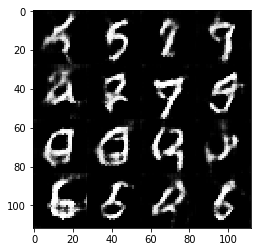

Epoch 0/2... Discriminator Loss: 1.3130... Generator Loss: 0.7737
Epoch 0/2... Discriminator Loss: 1.3604... Generator Loss: 0.6003
Epoch 0/2... Discriminator Loss: 1.2756... Generator Loss: 0.8061
Epoch 0/2... Discriminator Loss: 1.2361... Generator Loss: 1.1346
Epoch 0/2... Discriminator Loss: 1.3737... Generator Loss: 1.1110


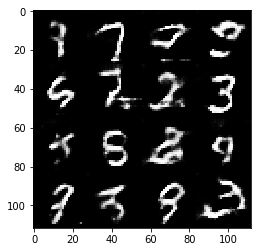

Epoch 0/2... Discriminator Loss: 1.3557... Generator Loss: 0.6299
Epoch 0/2... Discriminator Loss: 1.3242... Generator Loss: 1.1460
Epoch 0/2... Discriminator Loss: 1.4035... Generator Loss: 1.2022
Epoch 0/2... Discriminator Loss: 1.1579... Generator Loss: 1.2715
Epoch 0/2... Discriminator Loss: 1.3474... Generator Loss: 0.6982


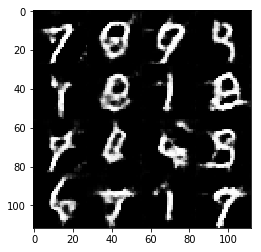

Epoch 0/2... Discriminator Loss: 1.3558... Generator Loss: 0.8175
Epoch 0/2... Discriminator Loss: 1.4670... Generator Loss: 0.4973
Epoch 0/2... Discriminator Loss: 1.4549... Generator Loss: 0.9501
Epoch 0/2... Discriminator Loss: 1.3568... Generator Loss: 0.7598
Epoch 0/2... Discriminator Loss: 1.3824... Generator Loss: 0.5926


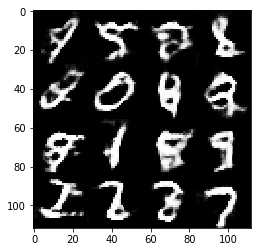

Epoch 0/2... Discriminator Loss: 1.2649... Generator Loss: 1.0812
Epoch 0/2... Discriminator Loss: 1.1463... Generator Loss: 0.7278
Epoch 0/2... Discriminator Loss: 1.1189... Generator Loss: 0.9143
Epoch 0/2... Discriminator Loss: 1.2700... Generator Loss: 1.1968
Epoch 0/2... Discriminator Loss: 1.0965... Generator Loss: 1.1870


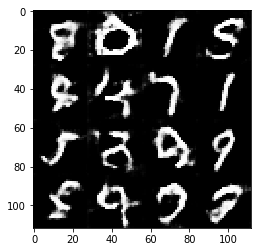

Epoch 0/2... Discriminator Loss: 1.2716... Generator Loss: 1.1234
Epoch 0/2... Discriminator Loss: 1.2261... Generator Loss: 1.1833
Epoch 0/2... Discriminator Loss: 1.1974... Generator Loss: 0.9435
Epoch 0/2... Discriminator Loss: 1.4835... Generator Loss: 0.5033
Epoch 0/2... Discriminator Loss: 1.3227... Generator Loss: 0.7077


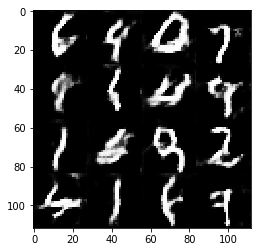

Epoch 0/2... Discriminator Loss: 1.2689... Generator Loss: 1.3801
Epoch 0/2... Discriminator Loss: 1.3727... Generator Loss: 0.6318
Epoch 0/2... Discriminator Loss: 1.5183... Generator Loss: 1.2373
Epoch 0/2... Discriminator Loss: 1.3796... Generator Loss: 0.5533
Epoch 0/2... Discriminator Loss: 1.2008... Generator Loss: 1.2293


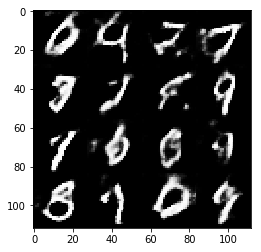

Epoch 0/2... Discriminator Loss: 1.2788... Generator Loss: 0.7234
Epoch 0/2... Discriminator Loss: 1.3371... Generator Loss: 0.7206
Epoch 0/2... Discriminator Loss: 1.4080... Generator Loss: 0.5644
Epoch 0/2... Discriminator Loss: 1.3452... Generator Loss: 0.5828
Epoch 0/2... Discriminator Loss: 1.2277... Generator Loss: 1.0355


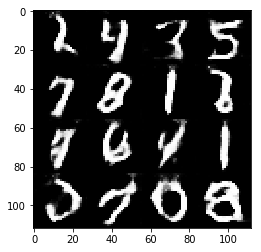

Epoch 0/2... Discriminator Loss: 1.4754... Generator Loss: 1.2911
Epoch 0/2... Discriminator Loss: 1.3820... Generator Loss: 0.7259
Epoch 0/2... Discriminator Loss: 1.2306... Generator Loss: 1.0041
Epoch 0/2... Discriminator Loss: 1.6142... Generator Loss: 0.4411
Epoch 0/2... Discriminator Loss: 1.2730... Generator Loss: 0.6865


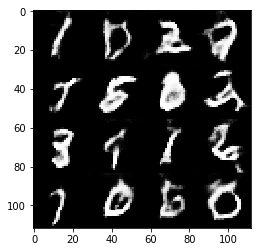

Epoch 0/2... Discriminator Loss: 1.4870... Generator Loss: 0.4584
Epoch 0/2... Discriminator Loss: 1.1779... Generator Loss: 1.1609
Epoch 0/2... Discriminator Loss: 1.0955... Generator Loss: 0.9273
Epoch 0/2... Discriminator Loss: 1.0750... Generator Loss: 1.0260
Epoch 0/2... Discriminator Loss: 1.1688... Generator Loss: 0.9835


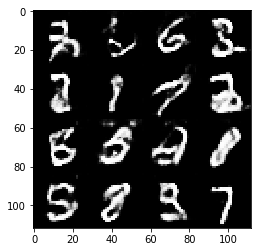

Epoch 0/2... Discriminator Loss: 1.2128... Generator Loss: 0.8188
Epoch 0/2... Discriminator Loss: 1.2704... Generator Loss: 1.0708
Epoch 0/2... Discriminator Loss: 1.2779... Generator Loss: 0.8930
Epoch 0/2... Discriminator Loss: 1.0492... Generator Loss: 1.0075
Epoch 0/2... Discriminator Loss: 1.2691... Generator Loss: 0.6132


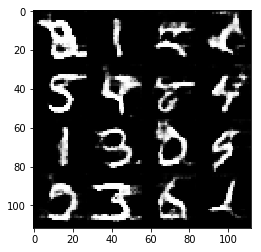

Epoch 0/2... Discriminator Loss: 1.2580... Generator Loss: 0.6421
Epoch 0/2... Discriminator Loss: 1.6131... Generator Loss: 0.5062
Epoch 0/2... Discriminator Loss: 1.1679... Generator Loss: 0.7883
Epoch 0/2... Discriminator Loss: 1.1513... Generator Loss: 0.9802
Epoch 0/2... Discriminator Loss: 1.3350... Generator Loss: 1.4800


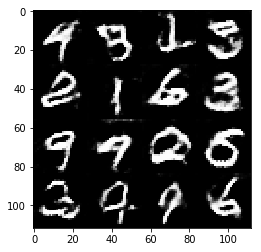

Epoch 0/2... Discriminator Loss: 1.2345... Generator Loss: 1.1543
Epoch 0/2... Discriminator Loss: 0.9573... Generator Loss: 1.2097
Epoch 0/2... Discriminator Loss: 1.3226... Generator Loss: 0.5653
Epoch 0/2... Discriminator Loss: 1.1854... Generator Loss: 1.6073
Epoch 0/2... Discriminator Loss: 1.2851... Generator Loss: 0.7313


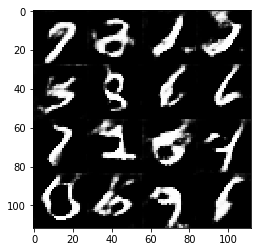

Epoch 0/2... Discriminator Loss: 1.7522... Generator Loss: 0.3839
Epoch 0/2... Discriminator Loss: 1.2622... Generator Loss: 0.6448
Epoch 0/2... Discriminator Loss: 1.2855... Generator Loss: 1.5670
Epoch 0/2... Discriminator Loss: 1.5812... Generator Loss: 2.2887
Epoch 0/2... Discriminator Loss: 1.2106... Generator Loss: 0.7777


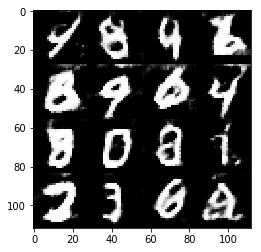

Epoch 0/2... Discriminator Loss: 1.0897... Generator Loss: 0.8897
Epoch 0/2... Discriminator Loss: 1.1638... Generator Loss: 0.8836
Epoch 0/2... Discriminator Loss: 1.1396... Generator Loss: 1.1707
Epoch 0/2... Discriminator Loss: 1.1648... Generator Loss: 0.7603
Epoch 0/2... Discriminator Loss: 1.5339... Generator Loss: 0.4699


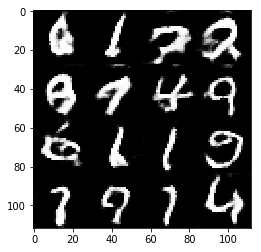

Epoch 0/2... Discriminator Loss: 1.4843... Generator Loss: 0.4541
Epoch 0/2... Discriminator Loss: 1.2099... Generator Loss: 1.3632
Epoch 0/2... Discriminator Loss: 1.1706... Generator Loss: 0.7919
Epoch 0/2... Discriminator Loss: 1.0504... Generator Loss: 1.0568
Epoch 0/2... Discriminator Loss: 1.2299... Generator Loss: 0.7842


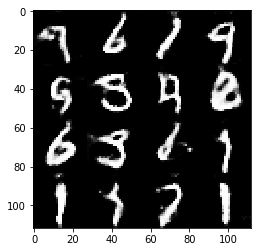

Epoch 0/2... Discriminator Loss: 1.1148... Generator Loss: 1.0720
Epoch 0/2... Discriminator Loss: 1.2564... Generator Loss: 1.5966
Epoch 0/2... Discriminator Loss: 1.7808... Generator Loss: 0.3090
Epoch 0/2... Discriminator Loss: 1.3676... Generator Loss: 0.6451
Epoch 0/2... Discriminator Loss: 1.1407... Generator Loss: 0.9629


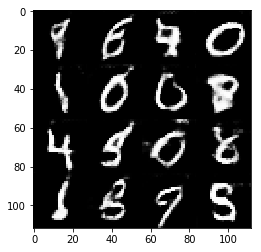

Epoch 0/2... Discriminator Loss: 1.0955... Generator Loss: 0.8730
Epoch 0/2... Discriminator Loss: 1.4153... Generator Loss: 0.5613
Epoch 0/2... Discriminator Loss: 1.1351... Generator Loss: 0.9987
Epoch 0/2... Discriminator Loss: 1.0743... Generator Loss: 1.2578
Epoch 0/2... Discriminator Loss: 1.3912... Generator Loss: 1.4546


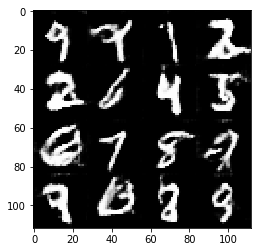

Epoch 0/2... Discriminator Loss: 1.2491... Generator Loss: 0.7388
Epoch 0/2... Discriminator Loss: 1.3531... Generator Loss: 0.9149
Epoch 0/2... Discriminator Loss: 1.3920... Generator Loss: 0.5468
Epoch 0/2... Discriminator Loss: 1.0736... Generator Loss: 0.9520
Epoch 0/2... Discriminator Loss: 1.2724... Generator Loss: 0.6662


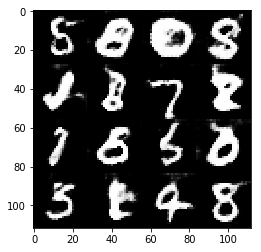

Epoch 0/2... Discriminator Loss: 1.0295... Generator Loss: 1.3910
Epoch 0/2... Discriminator Loss: 1.3300... Generator Loss: 0.6041
Epoch 0/2... Discriminator Loss: 1.4213... Generator Loss: 0.5320
Epoch 0/2... Discriminator Loss: 1.0939... Generator Loss: 1.0109
Epoch 0/2... Discriminator Loss: 1.1437... Generator Loss: 1.0358


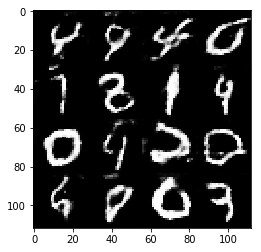

Epoch 0/2... Discriminator Loss: 1.4818... Generator Loss: 0.5912
Epoch 0/2... Discriminator Loss: 1.0659... Generator Loss: 1.1416
Epoch 0/2... Discriminator Loss: 1.0710... Generator Loss: 1.0318
Epoch 0/2... Discriminator Loss: 1.2349... Generator Loss: 1.0256
Epoch 0/2... Discriminator Loss: 1.3002... Generator Loss: 1.5389


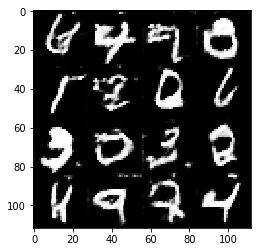

Epoch 0/2... Discriminator Loss: 1.3392... Generator Loss: 0.6166
Epoch 0/2... Discriminator Loss: 1.1849... Generator Loss: 0.7107
Epoch 0/2... Discriminator Loss: 1.3703... Generator Loss: 0.5470
Epoch 0/2... Discriminator Loss: 1.2302... Generator Loss: 0.6825
Epoch 0/2... Discriminator Loss: 1.3593... Generator Loss: 0.5062


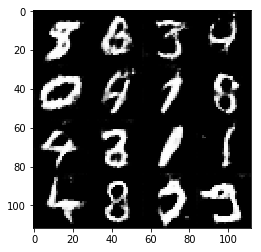

Epoch 0/2... Discriminator Loss: 1.2304... Generator Loss: 0.8468
Epoch 0/2... Discriminator Loss: 0.9411... Generator Loss: 1.1682
Epoch 0/2... Discriminator Loss: 1.2770... Generator Loss: 0.6720
Epoch 0/2... Discriminator Loss: 1.5002... Generator Loss: 0.5235
Epoch 0/2... Discriminator Loss: 0.9029... Generator Loss: 1.6338


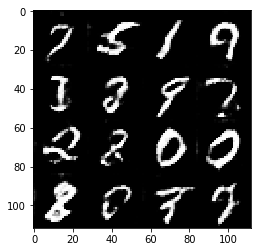

Epoch 0/2... Discriminator Loss: 1.2577... Generator Loss: 0.5931
Epoch 0/2... Discriminator Loss: 1.8508... Generator Loss: 0.3514
Epoch 0/2... Discriminator Loss: 1.2721... Generator Loss: 1.2600
Epoch 0/2... Discriminator Loss: 1.5438... Generator Loss: 0.4349
Epoch 0/2... Discriminator Loss: 1.2198... Generator Loss: 0.6002


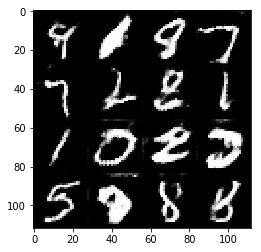

Epoch 0/2... Discriminator Loss: 1.0219... Generator Loss: 0.8770
Epoch 0/2... Discriminator Loss: 1.0634... Generator Loss: 0.9328
Epoch 0/2... Discriminator Loss: 1.6925... Generator Loss: 0.3867
Epoch 0/2... Discriminator Loss: 1.3937... Generator Loss: 2.0349
Epoch 0/2... Discriminator Loss: 2.2172... Generator Loss: 0.2060


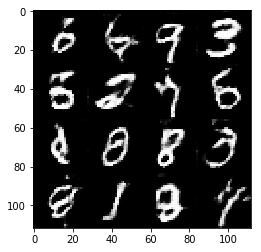

Epoch 0/2... Discriminator Loss: 1.2502... Generator Loss: 0.6586
Epoch 0/2... Discriminator Loss: 1.1540... Generator Loss: 0.7895
Epoch 0/2... Discriminator Loss: 1.1647... Generator Loss: 0.8443
Epoch 0/2... Discriminator Loss: 1.1991... Generator Loss: 1.3629
Epoch 0/2... Discriminator Loss: 1.2383... Generator Loss: 0.7395


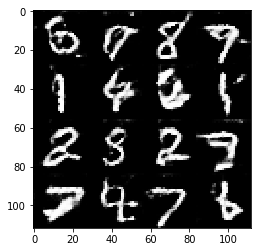

Epoch 0/2... Discriminator Loss: 1.5522... Generator Loss: 0.4916
Epoch 0/2... Discriminator Loss: 1.0819... Generator Loss: 0.9890
Epoch 0/2... Discriminator Loss: 1.5252... Generator Loss: 0.5304
Epoch 0/2... Discriminator Loss: 1.0685... Generator Loss: 0.8541
Epoch 0/2... Discriminator Loss: 2.2211... Generator Loss: 2.5537


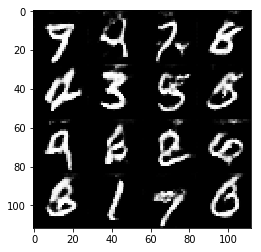

Epoch 0/2... Discriminator Loss: 1.0561... Generator Loss: 1.6903
Epoch 0/2... Discriminator Loss: 1.4163... Generator Loss: 0.5404
Epoch 0/2... Discriminator Loss: 1.6717... Generator Loss: 0.3949
Epoch 0/2... Discriminator Loss: 1.1513... Generator Loss: 0.7442
Epoch 0/2... Discriminator Loss: 0.8709... Generator Loss: 1.3371


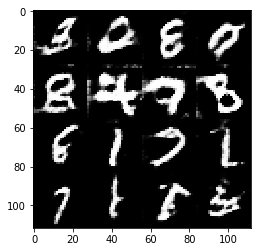

Epoch 0/2... Discriminator Loss: 1.1908... Generator Loss: 0.7061
Epoch 0/2... Discriminator Loss: 0.8363... Generator Loss: 1.4018
Epoch 0/2... Discriminator Loss: 0.9714... Generator Loss: 1.3883
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 1.0962
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.6578


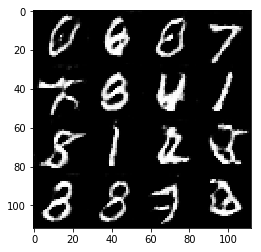

Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 1.2927
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.8630
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.5373


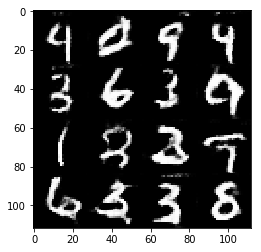

Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 2.4458
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 1.6494
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.2375
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 0.8911


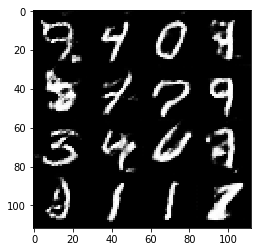

Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 0.4379
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.1052
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.7088... Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 2.3229... Generator Loss: 0.2575


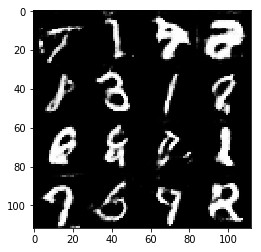

Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 1.1941
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.2713
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 2.0994
Epoch 1/2... Discriminator Loss: 1.7516... Generator Loss: 0.4032
Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 1.3427


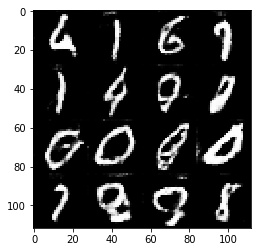

Epoch 1/2... Discriminator Loss: 1.8009... Generator Loss: 0.3196
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 1.6706
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.8366
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 1.0585
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.4718


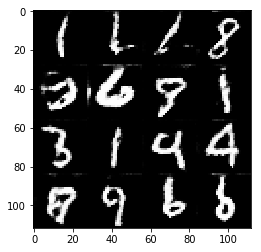

Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.8690
Epoch 1/2... Discriminator Loss: 1.7418... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.6010
Epoch 1/2... Discriminator Loss: 1.5677... Generator Loss: 0.4342


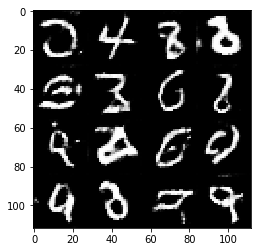

Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 0.8538
Epoch 1/2... Discriminator Loss: 1.9612... Generator Loss: 0.3036
Epoch 1/2... Discriminator Loss: 0.9705... Generator Loss: 1.0413
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.5689
Epoch 1/2... Discriminator Loss: 2.5109... Generator Loss: 0.1771


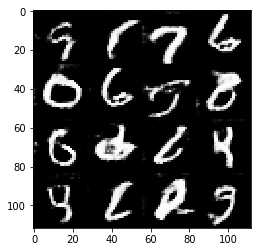

Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.6225


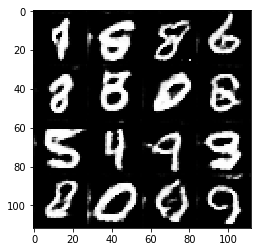

Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 2.1897... Generator Loss: 0.2666
Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 0.5019


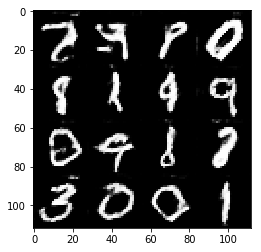

Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 1.4523
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 2.0988
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 1.1824


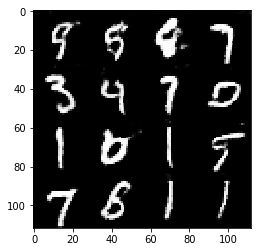

Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 1.4845
Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 1.3494
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 1.7101
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 0.9547


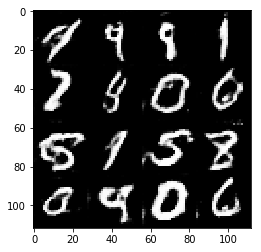

Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.6134
Epoch 1/2... Discriminator Loss: 0.8470... Generator Loss: 1.2103
Epoch 1/2... Discriminator Loss: 1.9761... Generator Loss: 3.2499


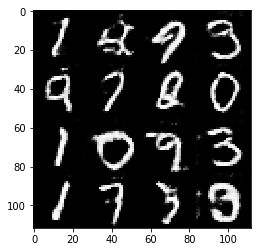

Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.2893
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.5433


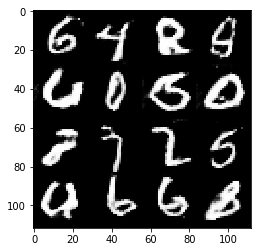

Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 0.9972
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 0.9666
Epoch 1/2... Discriminator Loss: 1.6220... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 1.7732... Generator Loss: 0.4661
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 0.8798


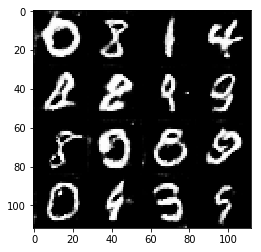

Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.6401
Epoch 1/2... Discriminator Loss: 0.9831... Generator Loss: 1.1307


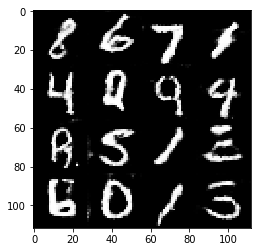

Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 1.0356
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.5616... Generator Loss: 0.4576
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.6882


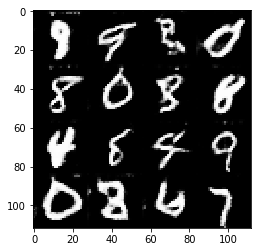

Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 1.4091
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 1.9906
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.7199... Generator Loss: 0.4183
Epoch 1/2... Discriminator Loss: 1.8558... Generator Loss: 0.4410


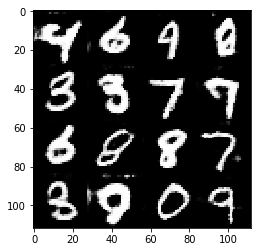

Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 1.8666
Epoch 1/2... Discriminator Loss: 1.6399... Generator Loss: 0.3795
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.1772
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 1.4588


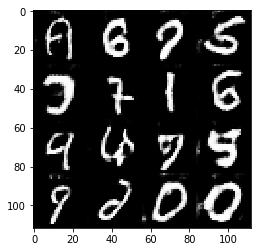

Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 2.2889
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.5996
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.2881


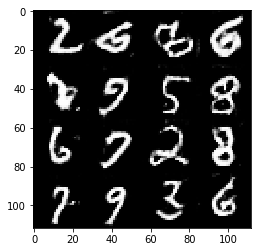

Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 1.8368
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 0.6872... Generator Loss: 1.5703
Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 1.8253


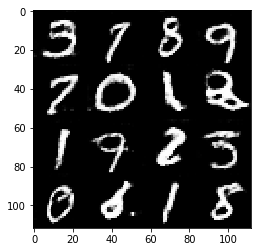

Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.5572
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 2.6008... Generator Loss: 0.1531
Epoch 1/2... Discriminator Loss: 1.6193... Generator Loss: 0.4453
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.5109


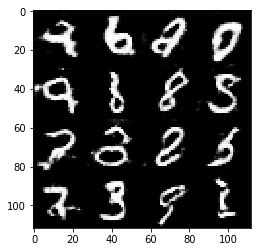

Epoch 1/2... Discriminator Loss: 1.6536... Generator Loss: 0.3565
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 1.4125
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 1.6553
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.8391


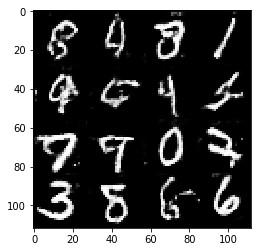

Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 2.4907
Epoch 1/2... Discriminator Loss: 0.8887... Generator Loss: 2.2599
Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 2.2251
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 0.8187


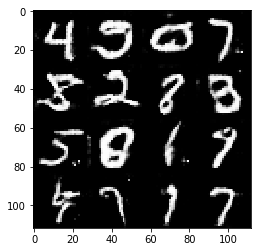

Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.7069
Epoch 1/2... Discriminator Loss: 2.0042... Generator Loss: 0.3715
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.8907... Generator Loss: 0.3495


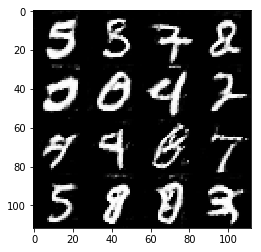

Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 0.9514
Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 1.6818
Epoch 1/2... Discriminator Loss: 2.5894... Generator Loss: 0.1970


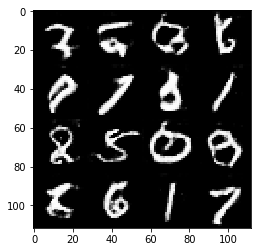

Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 2.3012
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 0.8993... Generator Loss: 0.9604
Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 1.3108


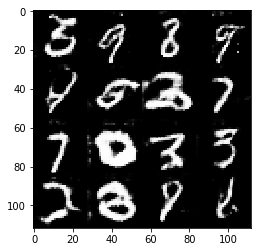

Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 1.3508
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.0955
Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.9938
Epoch 1/2... Discriminator Loss: 2.1019... Generator Loss: 0.3480


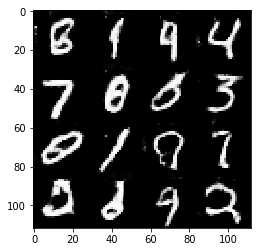

Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 1.4611
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 0.9902
Epoch 1/2... Discriminator Loss: 2.3948... Generator Loss: 0.2518


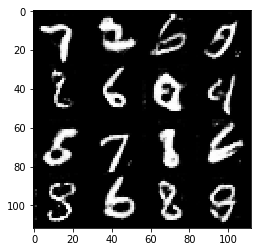

Epoch 1/2... Discriminator Loss: 1.8525... Generator Loss: 0.3774
Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 2.1353
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 1.0856
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.7304


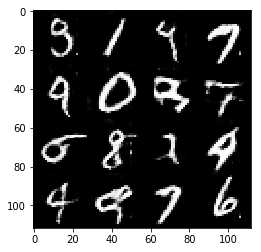

Epoch 1/2... Discriminator Loss: 0.6879... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.9824
Epoch 1/2... Discriminator Loss: 2.6530... Generator Loss: 0.1691
Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 1.2896


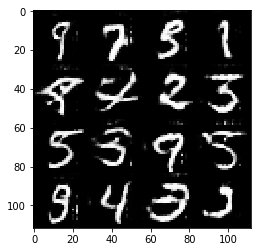

Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 1.5542
Epoch 1/2... Discriminator Loss: 1.9302... Generator Loss: 0.5026
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.6138
Epoch 1/2... Discriminator Loss: 1.6155... Generator Loss: 0.4951


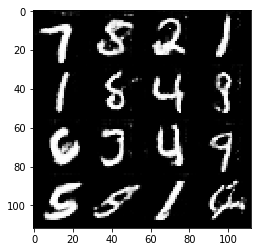

Epoch 1/2... Discriminator Loss: 1.2282... Generator Loss: 0.6131
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 0.6618... Generator Loss: 2.3209
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.7611


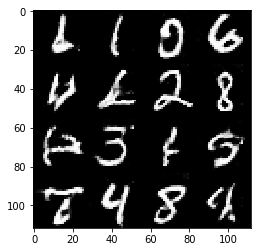

Epoch 1/2... Discriminator Loss: 1.6021... Generator Loss: 0.5478
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 1.5355
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.5294
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.0524


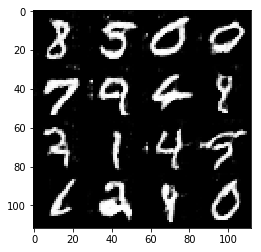

Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.9019... Generator Loss: 0.3123
Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 2.0878
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.8768
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.7721


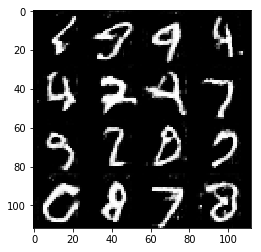

Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.6058
Epoch 1/2... Discriminator Loss: 1.4989... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.5953


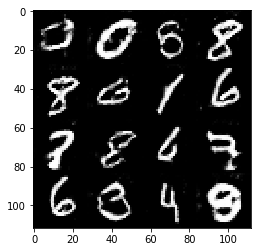

Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.2223
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.7097
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 1.0956
Epoch 1/2... Discriminator Loss: 1.5188... Generator Loss: 0.4985


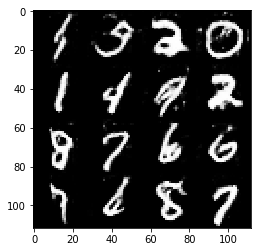

Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 1.5030
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 1.0850
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 1.5890


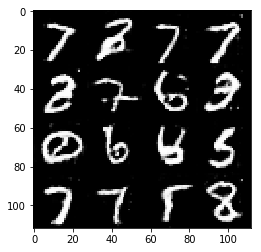

Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 1.2212


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1... Discriminator Loss: 3.1443... Generator Loss: 0.1553
Epoch 0/1... Discriminator Loss: 1.2207... Generator Loss: 0.6782
Epoch 0/1... Discriminator Loss: 0.5620... Generator Loss: 3.3449
Epoch 0/1... Discriminator Loss: 0.5286... Generator Loss: 2.5045


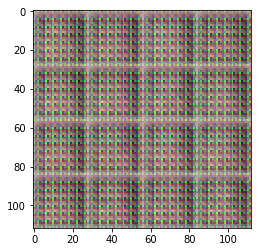

Epoch 0/1... Discriminator Loss: 2.1568... Generator Loss: 0.2610
Epoch 0/1... Discriminator Loss: 2.3766... Generator Loss: 0.3416
Epoch 0/1... Discriminator Loss: 1.1921... Generator Loss: 0.7463
Epoch 0/1... Discriminator Loss: 0.8185... Generator Loss: 1.6113
Epoch 0/1... Discriminator Loss: 0.9421... Generator Loss: 1.8427


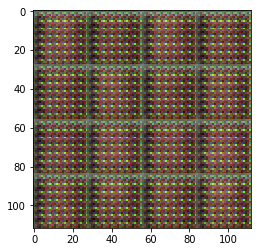

Epoch 0/1... Discriminator Loss: 0.6257... Generator Loss: 2.3476
Epoch 0/1... Discriminator Loss: 1.1733... Generator Loss: 0.7902
Epoch 0/1... Discriminator Loss: 0.9717... Generator Loss: 1.1185
Epoch 0/1... Discriminator Loss: 0.8487... Generator Loss: 1.3345
Epoch 0/1... Discriminator Loss: 1.0527... Generator Loss: 0.8239


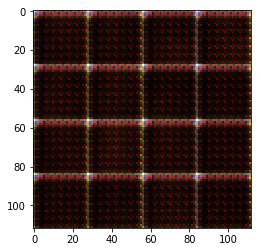

Epoch 0/1... Discriminator Loss: 0.6988... Generator Loss: 1.6225
Epoch 0/1... Discriminator Loss: 0.9997... Generator Loss: 1.7174
Epoch 0/1... Discriminator Loss: 1.1623... Generator Loss: 0.9841
Epoch 0/1... Discriminator Loss: 0.8899... Generator Loss: 1.6217
Epoch 0/1... Discriminator Loss: 1.1446... Generator Loss: 1.1743


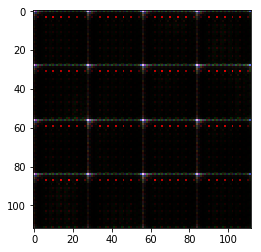

Epoch 0/1... Discriminator Loss: 2.2350... Generator Loss: 0.2138
Epoch 0/1... Discriminator Loss: 1.3841... Generator Loss: 0.5550
Epoch 0/1... Discriminator Loss: 1.2235... Generator Loss: 0.9411
Epoch 0/1... Discriminator Loss: 1.4429... Generator Loss: 0.5813
Epoch 0/1... Discriminator Loss: 1.1375... Generator Loss: 0.9996


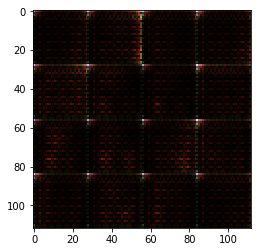

Epoch 0/1... Discriminator Loss: 1.0274... Generator Loss: 1.0513
Epoch 0/1... Discriminator Loss: 0.9757... Generator Loss: 1.3006
Epoch 0/1... Discriminator Loss: 1.4806... Generator Loss: 1.3327
Epoch 0/1... Discriminator Loss: 1.2655... Generator Loss: 1.4027
Epoch 0/1... Discriminator Loss: 1.3976... Generator Loss: 0.5643


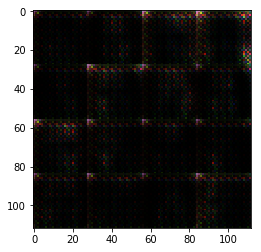

Epoch 0/1... Discriminator Loss: 1.0009... Generator Loss: 1.2409
Epoch 0/1... Discriminator Loss: 1.1089... Generator Loss: 2.4638
Epoch 0/1... Discriminator Loss: 1.1605... Generator Loss: 1.0695
Epoch 0/1... Discriminator Loss: 1.2352... Generator Loss: 0.8598
Epoch 0/1... Discriminator Loss: 1.4587... Generator Loss: 0.6051


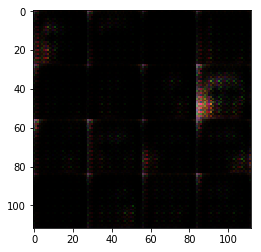

Epoch 0/1... Discriminator Loss: 1.2040... Generator Loss: 0.7985
Epoch 0/1... Discriminator Loss: 1.3102... Generator Loss: 0.8617
Epoch 0/1... Discriminator Loss: 1.1130... Generator Loss: 0.8039
Epoch 0/1... Discriminator Loss: 1.2149... Generator Loss: 1.0421
Epoch 0/1... Discriminator Loss: 1.3072... Generator Loss: 0.7287


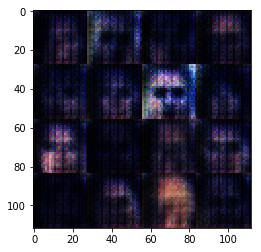

Epoch 0/1... Discriminator Loss: 1.7590... Generator Loss: 0.5484
Epoch 0/1... Discriminator Loss: 1.5057... Generator Loss: 0.8725
Epoch 0/1... Discriminator Loss: 1.1710... Generator Loss: 0.8054
Epoch 0/1... Discriminator Loss: 1.3536... Generator Loss: 0.9728
Epoch 0/1... Discriminator Loss: 1.3007... Generator Loss: 0.7353


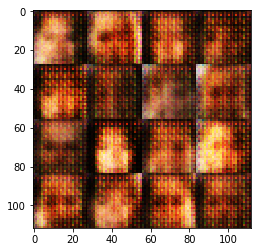

Epoch 0/1... Discriminator Loss: 1.3415... Generator Loss: 0.5831
Epoch 0/1... Discriminator Loss: 1.6552... Generator Loss: 0.6682
Epoch 0/1... Discriminator Loss: 1.5116... Generator Loss: 1.4247
Epoch 0/1... Discriminator Loss: 1.3461... Generator Loss: 0.7342
Epoch 0/1... Discriminator Loss: 1.4631... Generator Loss: 0.6194


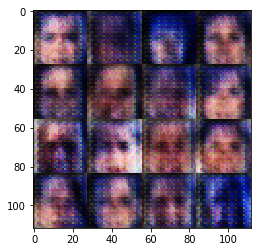

Epoch 0/1... Discriminator Loss: 1.3767... Generator Loss: 0.9604
Epoch 0/1... Discriminator Loss: 1.2293... Generator Loss: 0.8017
Epoch 0/1... Discriminator Loss: 1.2585... Generator Loss: 0.8297
Epoch 0/1... Discriminator Loss: 1.3860... Generator Loss: 1.0298
Epoch 0/1... Discriminator Loss: 1.1420... Generator Loss: 0.9281


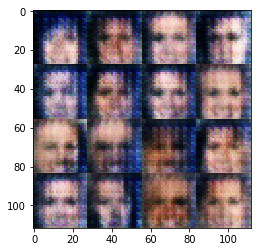

Epoch 0/1... Discriminator Loss: 1.3201... Generator Loss: 0.8048
Epoch 0/1... Discriminator Loss: 1.2889... Generator Loss: 0.7382
Epoch 0/1... Discriminator Loss: 1.3335... Generator Loss: 0.6660
Epoch 0/1... Discriminator Loss: 1.2873... Generator Loss: 1.0044
Epoch 0/1... Discriminator Loss: 1.3310... Generator Loss: 0.7597


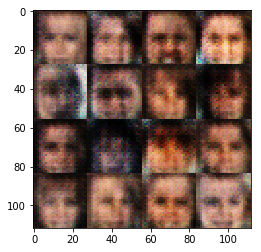

Epoch 0/1... Discriminator Loss: 1.4544... Generator Loss: 1.0835
Epoch 0/1... Discriminator Loss: 1.5860... Generator Loss: 0.5561
Epoch 0/1... Discriminator Loss: 1.3724... Generator Loss: 0.7551
Epoch 0/1... Discriminator Loss: 1.4485... Generator Loss: 0.7264
Epoch 0/1... Discriminator Loss: 1.4846... Generator Loss: 0.7937


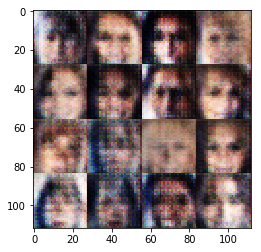

Epoch 0/1... Discriminator Loss: 1.5366... Generator Loss: 0.8460
Epoch 0/1... Discriminator Loss: 1.2683... Generator Loss: 0.6742
Epoch 0/1... Discriminator Loss: 1.4508... Generator Loss: 1.3006
Epoch 0/1... Discriminator Loss: 1.2332... Generator Loss: 1.1633
Epoch 0/1... Discriminator Loss: 1.1188... Generator Loss: 1.0128


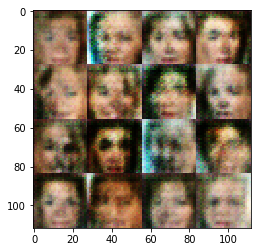

Epoch 0/1... Discriminator Loss: 1.3370... Generator Loss: 0.9175
Epoch 0/1... Discriminator Loss: 1.1526... Generator Loss: 0.9740
Epoch 0/1... Discriminator Loss: 1.4978... Generator Loss: 0.6863
Epoch 0/1... Discriminator Loss: 1.3751... Generator Loss: 0.8069
Epoch 0/1... Discriminator Loss: 1.4296... Generator Loss: 0.6741


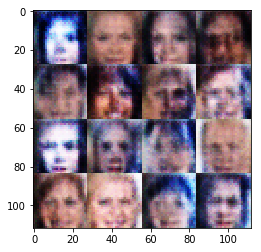

Epoch 0/1... Discriminator Loss: 1.0804... Generator Loss: 0.9849
Epoch 0/1... Discriminator Loss: 1.4757... Generator Loss: 0.9371
Epoch 0/1... Discriminator Loss: 1.3870... Generator Loss: 0.7403
Epoch 0/1... Discriminator Loss: 1.4192... Generator Loss: 0.9156
Epoch 0/1... Discriminator Loss: 1.4149... Generator Loss: 0.8493


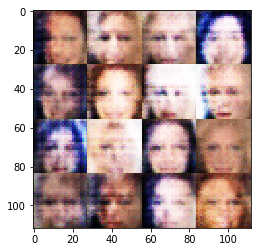

Epoch 0/1... Discriminator Loss: 1.2863... Generator Loss: 0.8267
Epoch 0/1... Discriminator Loss: 1.3097... Generator Loss: 0.7933
Epoch 0/1... Discriminator Loss: 1.1565... Generator Loss: 0.8441
Epoch 0/1... Discriminator Loss: 1.3666... Generator Loss: 0.7906
Epoch 0/1... Discriminator Loss: 1.2839... Generator Loss: 0.7219


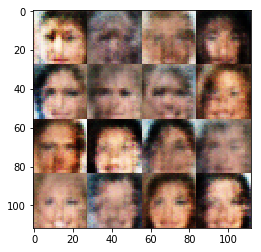

Epoch 0/1... Discriminator Loss: 1.5846... Generator Loss: 0.6019
Epoch 0/1... Discriminator Loss: 1.1904... Generator Loss: 0.8994
Epoch 0/1... Discriminator Loss: 1.2650... Generator Loss: 1.0261
Epoch 0/1... Discriminator Loss: 1.5974... Generator Loss: 0.6444
Epoch 0/1... Discriminator Loss: 1.3533... Generator Loss: 0.8770


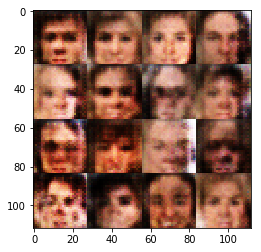

Epoch 0/1... Discriminator Loss: 1.3441... Generator Loss: 0.7550
Epoch 0/1... Discriminator Loss: 1.4347... Generator Loss: 0.6379
Epoch 0/1... Discriminator Loss: 1.3764... Generator Loss: 0.8143
Epoch 0/1... Discriminator Loss: 1.3869... Generator Loss: 0.7634
Epoch 0/1... Discriminator Loss: 1.4001... Generator Loss: 0.7113


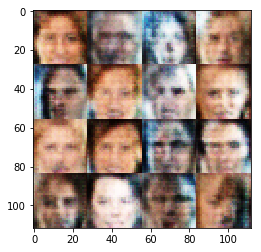

Epoch 0/1... Discriminator Loss: 1.2815... Generator Loss: 0.7818
Epoch 0/1... Discriminator Loss: 1.4001... Generator Loss: 0.7615
Epoch 0/1... Discriminator Loss: 1.2444... Generator Loss: 0.9016
Epoch 0/1... Discriminator Loss: 1.2645... Generator Loss: 0.8892
Epoch 0/1... Discriminator Loss: 1.2960... Generator Loss: 1.0076


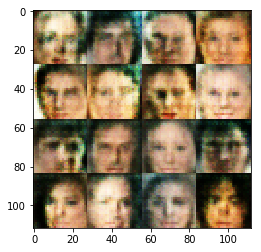

Epoch 0/1... Discriminator Loss: 1.3850... Generator Loss: 0.7566
Epoch 0/1... Discriminator Loss: 1.3104... Generator Loss: 1.0551
Epoch 0/1... Discriminator Loss: 1.5668... Generator Loss: 0.7820
Epoch 0/1... Discriminator Loss: 1.3991... Generator Loss: 0.7963
Epoch 0/1... Discriminator Loss: 1.3149... Generator Loss: 1.0897


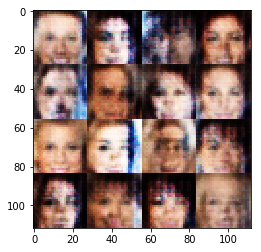

Epoch 0/1... Discriminator Loss: 1.1224... Generator Loss: 0.9049
Epoch 0/1... Discriminator Loss: 1.3818... Generator Loss: 0.7915
Epoch 0/1... Discriminator Loss: 1.4190... Generator Loss: 0.6416
Epoch 0/1... Discriminator Loss: 1.4818... Generator Loss: 0.5859
Epoch 0/1... Discriminator Loss: 1.2290... Generator Loss: 0.6866


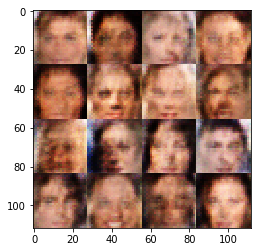

Epoch 0/1... Discriminator Loss: 1.2691... Generator Loss: 0.8082
Epoch 0/1... Discriminator Loss: 1.3937... Generator Loss: 0.7375
Epoch 0/1... Discriminator Loss: 1.2459... Generator Loss: 0.8387
Epoch 0/1... Discriminator Loss: 1.3138... Generator Loss: 0.7658
Epoch 0/1... Discriminator Loss: 1.5075... Generator Loss: 0.6053


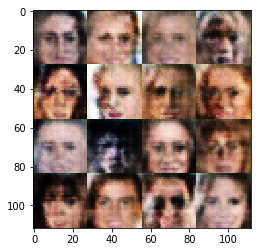

Epoch 0/1... Discriminator Loss: 1.2106... Generator Loss: 0.8200
Epoch 0/1... Discriminator Loss: 1.2235... Generator Loss: 0.9199
Epoch 0/1... Discriminator Loss: 1.5567... Generator Loss: 0.6110
Epoch 0/1... Discriminator Loss: 1.3595... Generator Loss: 0.7521
Epoch 0/1... Discriminator Loss: 1.1998... Generator Loss: 0.9314


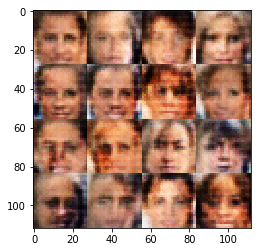

Epoch 0/1... Discriminator Loss: 1.2152... Generator Loss: 1.1698
Epoch 0/1... Discriminator Loss: 1.6100... Generator Loss: 0.7757
Epoch 0/1... Discriminator Loss: 1.3432... Generator Loss: 0.6510
Epoch 0/1... Discriminator Loss: 1.3610... Generator Loss: 0.7521
Epoch 0/1... Discriminator Loss: 1.2898... Generator Loss: 0.7645


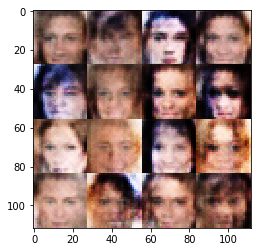

Epoch 0/1... Discriminator Loss: 1.1125... Generator Loss: 0.9652
Epoch 0/1... Discriminator Loss: 1.1916... Generator Loss: 0.8994
Epoch 0/1... Discriminator Loss: 1.3589... Generator Loss: 0.7174
Epoch 0/1... Discriminator Loss: 1.2982... Generator Loss: 0.9221
Epoch 0/1... Discriminator Loss: 1.1786... Generator Loss: 1.0548


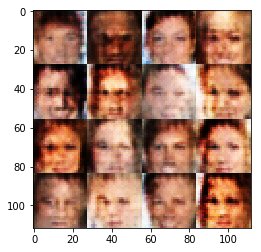

Epoch 0/1... Discriminator Loss: 1.2213... Generator Loss: 0.8162
Epoch 0/1... Discriminator Loss: 1.3262... Generator Loss: 0.7739
Epoch 0/1... Discriminator Loss: 1.3689... Generator Loss: 0.7716
Epoch 0/1... Discriminator Loss: 1.4278... Generator Loss: 0.8184
Epoch 0/1... Discriminator Loss: 1.4850... Generator Loss: 0.7008


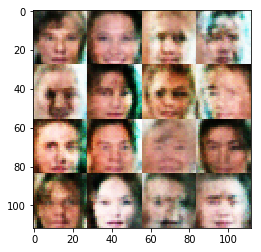

Epoch 0/1... Discriminator Loss: 1.4649... Generator Loss: 0.6576
Epoch 0/1... Discriminator Loss: 1.4420... Generator Loss: 0.8533
Epoch 0/1... Discriminator Loss: 1.2650... Generator Loss: 0.7880
Epoch 0/1... Discriminator Loss: 1.1829... Generator Loss: 1.0713
Epoch 0/1... Discriminator Loss: 1.1592... Generator Loss: 0.9323


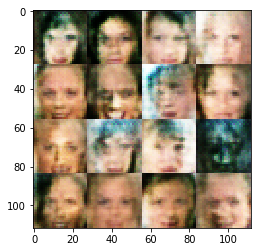

Epoch 0/1... Discriminator Loss: 1.3443... Generator Loss: 1.0467
Epoch 0/1... Discriminator Loss: 1.4144... Generator Loss: 0.8115
Epoch 0/1... Discriminator Loss: 1.4128... Generator Loss: 0.8447
Epoch 0/1... Discriminator Loss: 1.5981... Generator Loss: 0.7034
Epoch 0/1... Discriminator Loss: 1.3214... Generator Loss: 1.2186


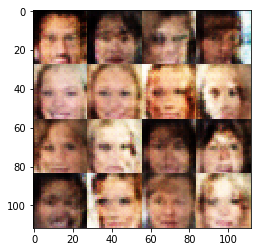

Epoch 0/1... Discriminator Loss: 1.0585... Generator Loss: 1.0322
Epoch 0/1... Discriminator Loss: 1.3766... Generator Loss: 0.7045
Epoch 0/1... Discriminator Loss: 1.2699... Generator Loss: 0.8431
Epoch 0/1... Discriminator Loss: 1.3818... Generator Loss: 0.7024
Epoch 0/1... Discriminator Loss: 1.5226... Generator Loss: 0.7549


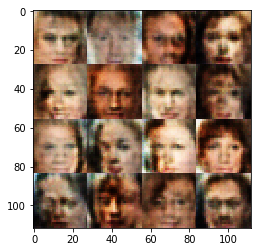

Epoch 0/1... Discriminator Loss: 1.3454... Generator Loss: 0.7276
Epoch 0/1... Discriminator Loss: 1.3199... Generator Loss: 0.7759
Epoch 0/1... Discriminator Loss: 1.1230... Generator Loss: 1.2754
Epoch 0/1... Discriminator Loss: 1.2679... Generator Loss: 0.9051
Epoch 0/1... Discriminator Loss: 1.3218... Generator Loss: 0.8882


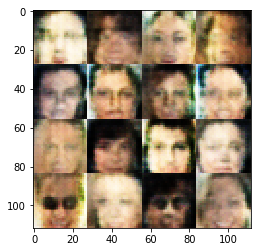

Epoch 0/1... Discriminator Loss: 1.3470... Generator Loss: 0.7808
Epoch 0/1... Discriminator Loss: 1.2674... Generator Loss: 0.9210
Epoch 0/1... Discriminator Loss: 1.1064... Generator Loss: 0.9524
Epoch 0/1... Discriminator Loss: 1.1480... Generator Loss: 0.8725
Epoch 0/1... Discriminator Loss: 1.6610... Generator Loss: 0.3862


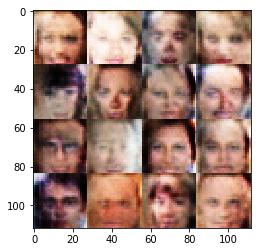

Epoch 0/1... Discriminator Loss: 1.3557... Generator Loss: 0.7402
Epoch 0/1... Discriminator Loss: 1.2289... Generator Loss: 1.0547
Epoch 0/1... Discriminator Loss: 1.2531... Generator Loss: 0.7458
Epoch 0/1... Discriminator Loss: 1.2304... Generator Loss: 0.7369
Epoch 0/1... Discriminator Loss: 1.1503... Generator Loss: 1.1796


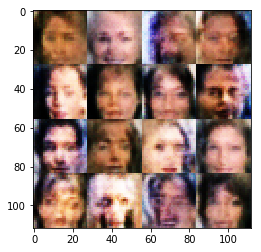

Epoch 0/1... Discriminator Loss: 1.4606... Generator Loss: 0.5334
Epoch 0/1... Discriminator Loss: 1.1474... Generator Loss: 0.8907
Epoch 0/1... Discriminator Loss: 1.2961... Generator Loss: 1.1760
Epoch 0/1... Discriminator Loss: 1.1958... Generator Loss: 0.9581
Epoch 0/1... Discriminator Loss: 1.2235... Generator Loss: 0.6644


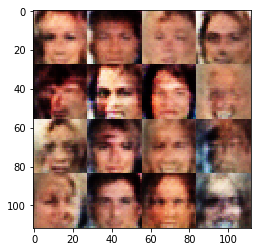

Epoch 0/1... Discriminator Loss: 1.3144... Generator Loss: 1.1168
Epoch 0/1... Discriminator Loss: 1.0914... Generator Loss: 0.8398
Epoch 0/1... Discriminator Loss: 1.3640... Generator Loss: 0.9847
Epoch 0/1... Discriminator Loss: 1.2343... Generator Loss: 0.8845
Epoch 0/1... Discriminator Loss: 1.4447... Generator Loss: 0.5534


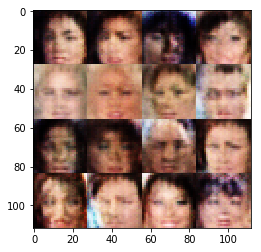

Epoch 0/1... Discriminator Loss: 1.1521... Generator Loss: 1.0055
Epoch 0/1... Discriminator Loss: 1.1413... Generator Loss: 1.1435
Epoch 0/1... Discriminator Loss: 1.0434... Generator Loss: 1.1739
Epoch 0/1... Discriminator Loss: 1.1181... Generator Loss: 1.4608
Epoch 0/1... Discriminator Loss: 1.0780... Generator Loss: 1.2187


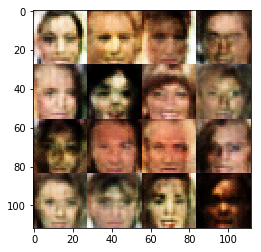

Epoch 0/1... Discriminator Loss: 0.9998... Generator Loss: 1.1156
Epoch 0/1... Discriminator Loss: 1.3012... Generator Loss: 0.6881
Epoch 0/1... Discriminator Loss: 1.1383... Generator Loss: 1.4296
Epoch 0/1... Discriminator Loss: 1.1521... Generator Loss: 0.7647
Epoch 0/1... Discriminator Loss: 1.4080... Generator Loss: 1.2709


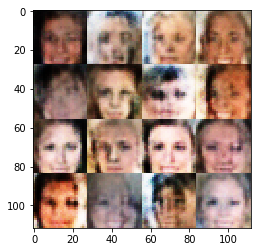

Epoch 0/1... Discriminator Loss: 1.2190... Generator Loss: 1.0278
Epoch 0/1... Discriminator Loss: 0.9926... Generator Loss: 1.1310
Epoch 0/1... Discriminator Loss: 1.6070... Generator Loss: 0.4605
Epoch 0/1... Discriminator Loss: 1.3629... Generator Loss: 0.6676
Epoch 0/1... Discriminator Loss: 1.3441... Generator Loss: 0.8278


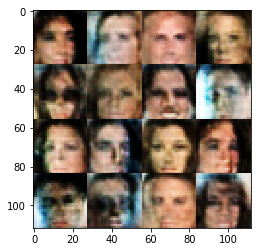

Epoch 0/1... Discriminator Loss: 1.4343... Generator Loss: 0.6088
Epoch 0/1... Discriminator Loss: 1.2850... Generator Loss: 1.2805
Epoch 0/1... Discriminator Loss: 1.2238... Generator Loss: 0.8533
Epoch 0/1... Discriminator Loss: 1.3341... Generator Loss: 0.7360
Epoch 0/1... Discriminator Loss: 1.1511... Generator Loss: 0.8930


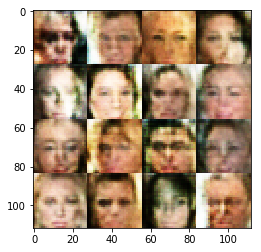

Epoch 0/1... Discriminator Loss: 1.3309... Generator Loss: 0.8062
Epoch 0/1... Discriminator Loss: 1.5998... Generator Loss: 0.4219
Epoch 0/1... Discriminator Loss: 1.4431... Generator Loss: 0.6829
Epoch 0/1... Discriminator Loss: 1.2737... Generator Loss: 0.7393
Epoch 0/1... Discriminator Loss: 1.5319... Generator Loss: 0.6152


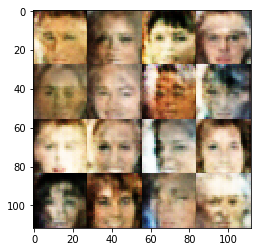

Epoch 0/1... Discriminator Loss: 1.1995... Generator Loss: 0.8266
Epoch 0/1... Discriminator Loss: 1.1473... Generator Loss: 0.7998
Epoch 0/1... Discriminator Loss: 1.1045... Generator Loss: 1.6066
Epoch 0/1... Discriminator Loss: 1.2650... Generator Loss: 0.7755
Epoch 0/1... Discriminator Loss: 1.2345... Generator Loss: 0.8110


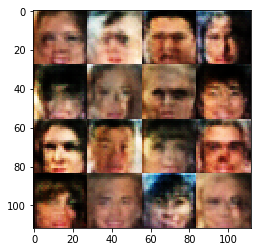

Epoch 0/1... Discriminator Loss: 1.1493... Generator Loss: 0.9834
Epoch 0/1... Discriminator Loss: 1.3961... Generator Loss: 0.5521
Epoch 0/1... Discriminator Loss: 0.9615... Generator Loss: 1.0440
Epoch 0/1... Discriminator Loss: 1.0395... Generator Loss: 1.0181
Epoch 0/1... Discriminator Loss: 1.1758... Generator Loss: 1.1181


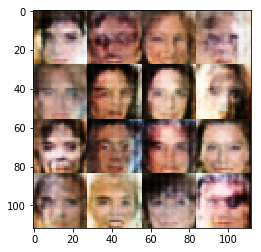

Epoch 0/1... Discriminator Loss: 1.2277... Generator Loss: 0.7514
Epoch 0/1... Discriminator Loss: 1.3222... Generator Loss: 0.6469
Epoch 0/1... Discriminator Loss: 1.1248... Generator Loss: 0.8578
Epoch 0/1... Discriminator Loss: 1.8952... Generator Loss: 1.8320
Epoch 0/1... Discriminator Loss: 1.2834... Generator Loss: 0.5920


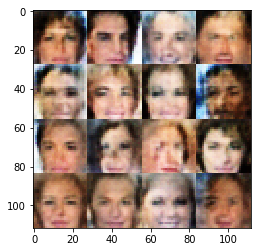

Epoch 0/1... Discriminator Loss: 1.4493... Generator Loss: 0.8963
Epoch 0/1... Discriminator Loss: 1.3990... Generator Loss: 0.6075
Epoch 0/1... Discriminator Loss: 1.1435... Generator Loss: 1.2063
Epoch 0/1... Discriminator Loss: 1.0369... Generator Loss: 1.6618
Epoch 0/1... Discriminator Loss: 1.7309... Generator Loss: 0.3261


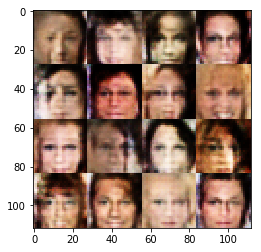

Epoch 0/1... Discriminator Loss: 1.0975... Generator Loss: 1.0209
Epoch 0/1... Discriminator Loss: 1.1988... Generator Loss: 1.0301
Epoch 0/1... Discriminator Loss: 1.2030... Generator Loss: 0.7523
Epoch 0/1... Discriminator Loss: 1.1636... Generator Loss: 0.8362
Epoch 0/1... Discriminator Loss: 0.9663... Generator Loss: 1.7293


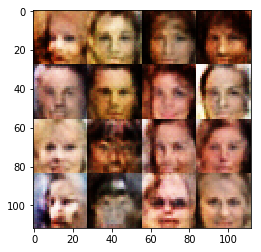

Epoch 0/1... Discriminator Loss: 1.3430... Generator Loss: 1.3788
Epoch 0/1... Discriminator Loss: 1.3608... Generator Loss: 0.6514
Epoch 0/1... Discriminator Loss: 1.4055... Generator Loss: 0.8511
Epoch 0/1... Discriminator Loss: 1.2737... Generator Loss: 0.8004
Epoch 0/1... Discriminator Loss: 0.9075... Generator Loss: 1.4965


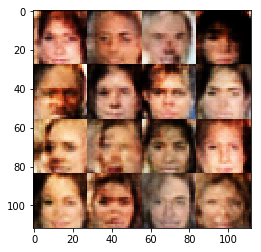

Epoch 0/1... Discriminator Loss: 1.0186... Generator Loss: 1.2314
Epoch 0/1... Discriminator Loss: 1.1460... Generator Loss: 1.3837
Epoch 0/1... Discriminator Loss: 1.5508... Generator Loss: 1.2747
Epoch 0/1... Discriminator Loss: 1.3988... Generator Loss: 0.9792
Epoch 0/1... Discriminator Loss: 1.3468... Generator Loss: 0.6705


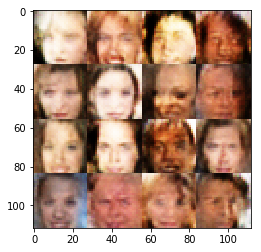

Epoch 0/1... Discriminator Loss: 1.0616... Generator Loss: 1.0557
Epoch 0/1... Discriminator Loss: 1.1964... Generator Loss: 0.9357
Epoch 0/1... Discriminator Loss: 1.3268... Generator Loss: 1.1849
Epoch 0/1... Discriminator Loss: 1.7255... Generator Loss: 0.3262
Epoch 0/1... Discriminator Loss: 1.0833... Generator Loss: 0.8484


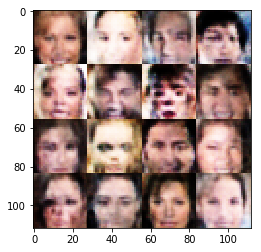

Epoch 0/1... Discriminator Loss: 1.1983... Generator Loss: 1.2914
Epoch 0/1... Discriminator Loss: 1.3890... Generator Loss: 0.6612
Epoch 0/1... Discriminator Loss: 1.3144... Generator Loss: 1.1680
Epoch 0/1... Discriminator Loss: 1.4273... Generator Loss: 0.8076
Epoch 0/1... Discriminator Loss: 1.3534... Generator Loss: 0.6572


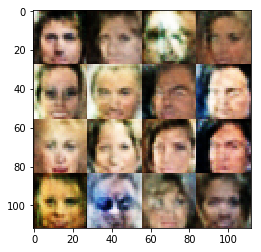

Epoch 0/1... Discriminator Loss: 1.1351... Generator Loss: 0.9393
Epoch 0/1... Discriminator Loss: 1.3216... Generator Loss: 0.8647
Epoch 0/1... Discriminator Loss: 1.0411... Generator Loss: 1.1795
Epoch 0/1... Discriminator Loss: 1.1796... Generator Loss: 0.6864
Epoch 0/1... Discriminator Loss: 0.9877... Generator Loss: 1.4679


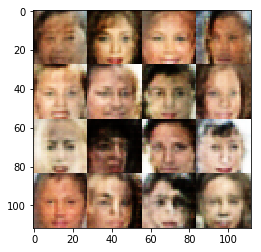

Epoch 0/1... Discriminator Loss: 1.0713... Generator Loss: 0.8907
Epoch 0/1... Discriminator Loss: 1.2106... Generator Loss: 0.7817
Epoch 0/1... Discriminator Loss: 0.9877... Generator Loss: 1.3414
Epoch 0/1... Discriminator Loss: 0.9713... Generator Loss: 1.5310
Epoch 0/1... Discriminator Loss: 1.0203... Generator Loss: 1.3892


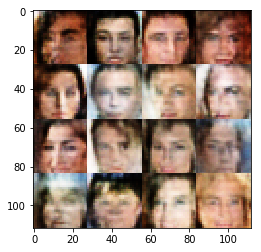

Epoch 0/1... Discriminator Loss: 1.3951... Generator Loss: 0.9598
Epoch 0/1... Discriminator Loss: 1.1276... Generator Loss: 0.8765
Epoch 0/1... Discriminator Loss: 1.1797... Generator Loss: 0.8180
Epoch 0/1... Discriminator Loss: 1.0841... Generator Loss: 0.9932
Epoch 0/1... Discriminator Loss: 1.1718... Generator Loss: 1.0578


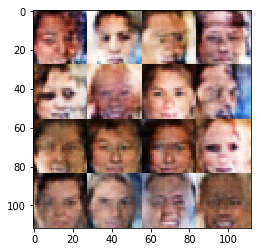

Epoch 0/1... Discriminator Loss: 0.9621... Generator Loss: 1.2698
Epoch 0/1... Discriminator Loss: 1.4094... Generator Loss: 0.7889
Epoch 0/1... Discriminator Loss: 1.0944... Generator Loss: 0.8403
Epoch 0/1... Discriminator Loss: 1.3459... Generator Loss: 0.8615
Epoch 0/1... Discriminator Loss: 1.4737... Generator Loss: 0.8978


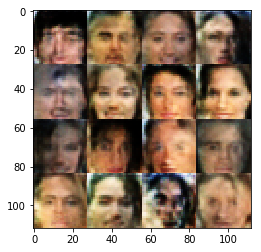

Epoch 0/1... Discriminator Loss: 1.3388... Generator Loss: 0.6369
Epoch 0/1... Discriminator Loss: 1.2269... Generator Loss: 1.1731
Epoch 0/1... Discriminator Loss: 1.2724... Generator Loss: 0.6898
Epoch 0/1... Discriminator Loss: 0.8903... Generator Loss: 1.2869
Epoch 0/1... Discriminator Loss: 1.1608... Generator Loss: 1.1067


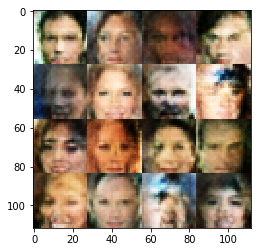

Epoch 0/1... Discriminator Loss: 1.4374... Generator Loss: 0.9310
Epoch 0/1... Discriminator Loss: 1.2671... Generator Loss: 0.7379
Epoch 0/1... Discriminator Loss: 1.4094... Generator Loss: 0.5179
Epoch 0/1... Discriminator Loss: 1.0378... Generator Loss: 1.1559
Epoch 0/1... Discriminator Loss: 1.3212... Generator Loss: 0.6315


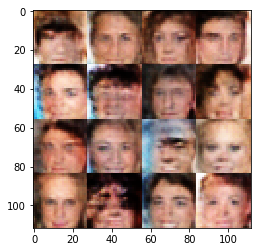

Epoch 0/1... Discriminator Loss: 1.2855... Generator Loss: 0.7858
Epoch 0/1... Discriminator Loss: 1.1570... Generator Loss: 0.7972
Epoch 0/1... Discriminator Loss: 1.0814... Generator Loss: 1.0825
Epoch 0/1... Discriminator Loss: 1.0238... Generator Loss: 2.0180
Epoch 0/1... Discriminator Loss: 1.3569... Generator Loss: 1.4108


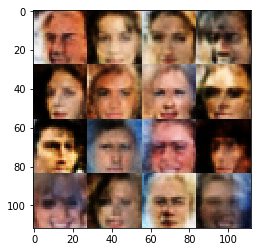

Epoch 0/1... Discriminator Loss: 1.4125... Generator Loss: 0.5182
Epoch 0/1... Discriminator Loss: 1.1571... Generator Loss: 0.9816
Epoch 0/1... Discriminator Loss: 1.3299... Generator Loss: 0.6699
Epoch 0/1... Discriminator Loss: 1.3092... Generator Loss: 0.8787
Epoch 0/1... Discriminator Loss: 1.4098... Generator Loss: 0.6534


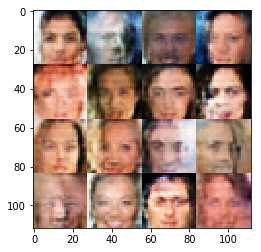

Epoch 0/1... Discriminator Loss: 1.0451... Generator Loss: 1.1869
Epoch 0/1... Discriminator Loss: 1.1072... Generator Loss: 1.2608
Epoch 0/1... Discriminator Loss: 1.1654... Generator Loss: 0.9516
Epoch 0/1... Discriminator Loss: 1.1486... Generator Loss: 0.8013
Epoch 0/1... Discriminator Loss: 1.2077... Generator Loss: 0.9592


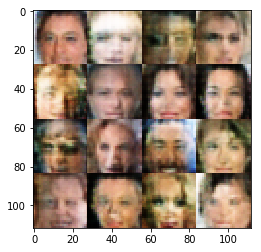

Epoch 0/1... Discriminator Loss: 1.5135... Generator Loss: 0.4679
Epoch 0/1... Discriminator Loss: 1.3929... Generator Loss: 0.6767
Epoch 0/1... Discriminator Loss: 1.3034... Generator Loss: 0.8385
Epoch 0/1... Discriminator Loss: 1.3931... Generator Loss: 0.5342
Epoch 0/1... Discriminator Loss: 1.3772... Generator Loss: 0.5852


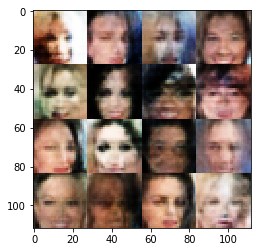

Epoch 0/1... Discriminator Loss: 0.9690... Generator Loss: 1.2613
Epoch 0/1... Discriminator Loss: 1.0760... Generator Loss: 1.2411
Epoch 0/1... Discriminator Loss: 1.1329... Generator Loss: 0.9535
Epoch 0/1... Discriminator Loss: 1.3796... Generator Loss: 0.6783
Epoch 0/1... Discriminator Loss: 1.1486... Generator Loss: 0.8248


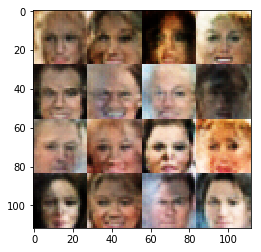

Epoch 0/1... Discriminator Loss: 1.1373... Generator Loss: 1.7906
Epoch 0/1... Discriminator Loss: 1.1663... Generator Loss: 0.7558
Epoch 0/1... Discriminator Loss: 2.1824... Generator Loss: 0.1989
Epoch 0/1... Discriminator Loss: 1.3373... Generator Loss: 0.7928
Epoch 0/1... Discriminator Loss: 1.0411... Generator Loss: 0.9116


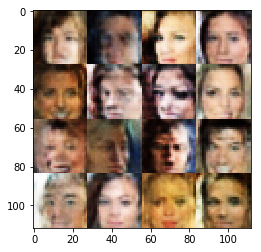

Epoch 0/1... Discriminator Loss: 1.0529... Generator Loss: 1.2075
Epoch 0/1... Discriminator Loss: 1.2993... Generator Loss: 0.8613
Epoch 0/1... Discriminator Loss: 1.4151... Generator Loss: 0.5577
Epoch 0/1... Discriminator Loss: 1.2255... Generator Loss: 0.9508
Epoch 0/1... Discriminator Loss: 1.1678... Generator Loss: 0.8697


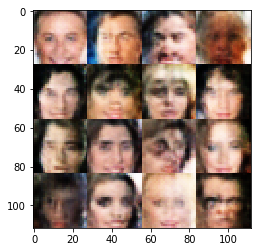

Epoch 0/1... Discriminator Loss: 1.1314... Generator Loss: 1.1399
Epoch 0/1... Discriminator Loss: 1.7259... Generator Loss: 0.5131
Epoch 0/1... Discriminator Loss: 1.2258... Generator Loss: 0.7746
Epoch 0/1... Discriminator Loss: 1.2728... Generator Loss: 0.7843
Epoch 0/1... Discriminator Loss: 1.2065... Generator Loss: 0.7919


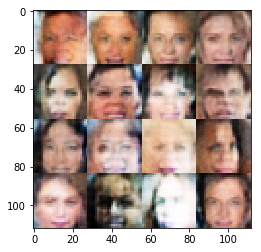

Epoch 0/1... Discriminator Loss: 1.1440... Generator Loss: 0.9039
Epoch 0/1... Discriminator Loss: 1.3399... Generator Loss: 0.6394
Epoch 0/1... Discriminator Loss: 1.2656... Generator Loss: 0.7778
Epoch 0/1... Discriminator Loss: 1.1175... Generator Loss: 0.8204
Epoch 0/1... Discriminator Loss: 1.1981... Generator Loss: 0.7775


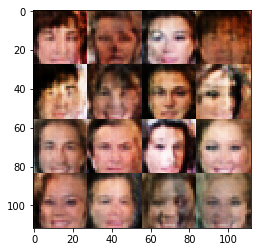

Epoch 0/1... Discriminator Loss: 1.1395... Generator Loss: 0.9181
Epoch 0/1... Discriminator Loss: 1.2243... Generator Loss: 0.8119
Epoch 0/1... Discriminator Loss: 0.9268... Generator Loss: 1.2589
Epoch 0/1... Discriminator Loss: 0.8825... Generator Loss: 1.2913
Epoch 0/1... Discriminator Loss: 1.3007... Generator Loss: 0.8712


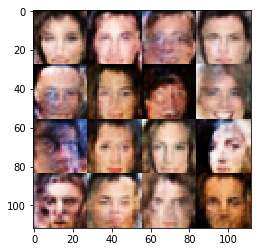

Epoch 0/1... Discriminator Loss: 1.2222... Generator Loss: 0.9960
Epoch 0/1... Discriminator Loss: 1.1429... Generator Loss: 1.0685
Epoch 0/1... Discriminator Loss: 0.7904... Generator Loss: 1.6134
Epoch 0/1... Discriminator Loss: 1.0680... Generator Loss: 0.8691
Epoch 0/1... Discriminator Loss: 1.0289... Generator Loss: 1.1035


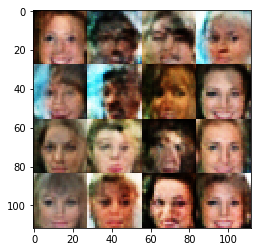

Epoch 0/1... Discriminator Loss: 1.1703... Generator Loss: 0.8388
Epoch 0/1... Discriminator Loss: 1.3697... Generator Loss: 0.5804
Epoch 0/1... Discriminator Loss: 1.4811... Generator Loss: 0.4621
Epoch 0/1... Discriminator Loss: 1.2562... Generator Loss: 1.5399
Epoch 0/1... Discriminator Loss: 1.4403... Generator Loss: 0.8180


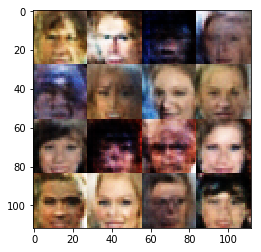

Epoch 0/1... Discriminator Loss: 0.7735... Generator Loss: 1.4291
Epoch 0/1... Discriminator Loss: 1.1635... Generator Loss: 0.9719
Epoch 0/1... Discriminator Loss: 1.1730... Generator Loss: 1.1777
Epoch 0/1... Discriminator Loss: 1.1898... Generator Loss: 0.9928
Epoch 0/1... Discriminator Loss: 1.4286... Generator Loss: 0.7104


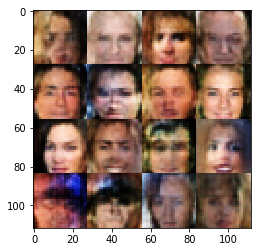

Epoch 0/1... Discriminator Loss: 1.1431... Generator Loss: 0.8474
Epoch 0/1... Discriminator Loss: 1.2302... Generator Loss: 0.8207
Epoch 0/1... Discriminator Loss: 1.1742... Generator Loss: 1.4639
Epoch 0/1... Discriminator Loss: 1.4225... Generator Loss: 0.5791
Epoch 0/1... Discriminator Loss: 1.2775... Generator Loss: 0.8990


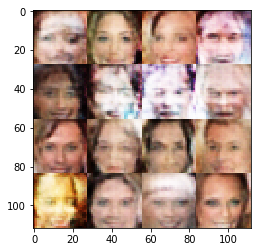

Epoch 0/1... Discriminator Loss: 1.1557... Generator Loss: 0.7867
Epoch 0/1... Discriminator Loss: 1.2055... Generator Loss: 0.7658
Epoch 0/1... Discriminator Loss: 0.8738... Generator Loss: 1.1255
Epoch 0/1... Discriminator Loss: 1.2026... Generator Loss: 0.8115
Epoch 0/1... Discriminator Loss: 1.1175... Generator Loss: 1.2487


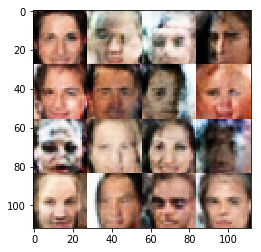

Epoch 0/1... Discriminator Loss: 1.5757... Generator Loss: 0.4477
Epoch 0/1... Discriminator Loss: 1.4872... Generator Loss: 0.4822
Epoch 0/1... Discriminator Loss: 1.1396... Generator Loss: 1.0046
Epoch 0/1... Discriminator Loss: 1.0419... Generator Loss: 0.9031
Epoch 0/1... Discriminator Loss: 1.2011... Generator Loss: 0.8400


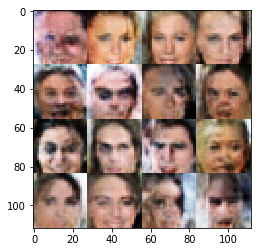

Epoch 0/1... Discriminator Loss: 1.2649... Generator Loss: 0.7427
Epoch 0/1... Discriminator Loss: 1.1364... Generator Loss: 0.9023
Epoch 0/1... Discriminator Loss: 1.1341... Generator Loss: 0.9121
Epoch 0/1... Discriminator Loss: 1.2114... Generator Loss: 0.8127
Epoch 0/1... Discriminator Loss: 1.1218... Generator Loss: 1.4481


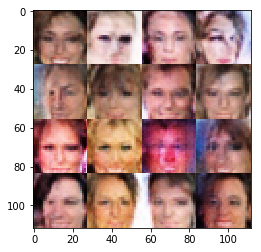

Epoch 0/1... Discriminator Loss: 1.2114... Generator Loss: 0.6723
Epoch 0/1... Discriminator Loss: 1.2615... Generator Loss: 0.6881
Epoch 0/1... Discriminator Loss: 1.2334... Generator Loss: 0.7302
Epoch 0/1... Discriminator Loss: 0.9826... Generator Loss: 1.0322
Epoch 0/1... Discriminator Loss: 1.1112... Generator Loss: 1.0913


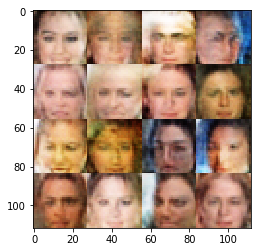

Epoch 0/1... Discriminator Loss: 1.1004... Generator Loss: 0.8284
Epoch 0/1... Discriminator Loss: 1.1847... Generator Loss: 0.6632
Epoch 0/1... Discriminator Loss: 1.3198... Generator Loss: 0.8004
Epoch 0/1... Discriminator Loss: 1.2920... Generator Loss: 0.9725
Epoch 0/1... Discriminator Loss: 1.2601... Generator Loss: 0.8366


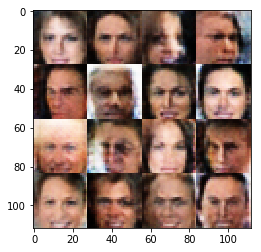

Epoch 0/1... Discriminator Loss: 1.2850... Generator Loss: 0.6667
Epoch 0/1... Discriminator Loss: 1.3525... Generator Loss: 0.8045
Epoch 0/1... Discriminator Loss: 1.0717... Generator Loss: 0.9929
Epoch 0/1... Discriminator Loss: 0.9249... Generator Loss: 1.1670
Epoch 0/1... Discriminator Loss: 1.2114... Generator Loss: 0.9306


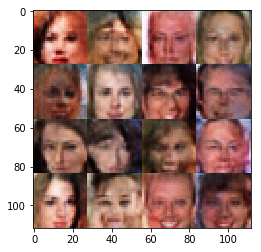

Epoch 0/1... Discriminator Loss: 1.3184... Generator Loss: 0.6779
Epoch 0/1... Discriminator Loss: 1.2995... Generator Loss: 0.8114
Epoch 0/1... Discriminator Loss: 1.2812... Generator Loss: 0.7648
Epoch 0/1... Discriminator Loss: 1.3801... Generator Loss: 0.7460
Epoch 0/1... Discriminator Loss: 1.0669... Generator Loss: 0.9237


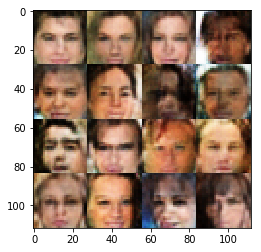

Epoch 0/1... Discriminator Loss: 1.2395... Generator Loss: 0.7269
Epoch 0/1... Discriminator Loss: 1.2666... Generator Loss: 1.1261
Epoch 0/1... Discriminator Loss: 1.2411... Generator Loss: 0.8003
Epoch 0/1... Discriminator Loss: 1.1082... Generator Loss: 0.8721
Epoch 0/1... Discriminator Loss: 1.2383... Generator Loss: 1.0096


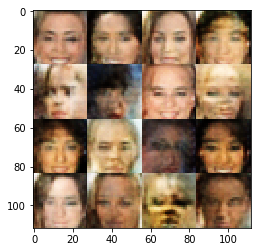

Epoch 0/1... Discriminator Loss: 1.1195... Generator Loss: 0.8320
Epoch 0/1... Discriminator Loss: 1.1135... Generator Loss: 0.8568
Epoch 0/1... Discriminator Loss: 1.3030... Generator Loss: 0.7748
Epoch 0/1... Discriminator Loss: 1.4058... Generator Loss: 0.6331
Epoch 0/1... Discriminator Loss: 1.2407... Generator Loss: 0.8684


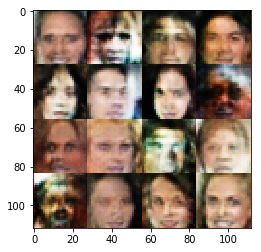

Epoch 0/1... Discriminator Loss: 1.0795... Generator Loss: 0.8157
Epoch 0/1... Discriminator Loss: 1.1735... Generator Loss: 0.7687
Epoch 0/1... Discriminator Loss: 1.2897... Generator Loss: 0.7216
Epoch 0/1... Discriminator Loss: 0.9808... Generator Loss: 1.0426
Epoch 0/1... Discriminator Loss: 0.8635... Generator Loss: 1.1207


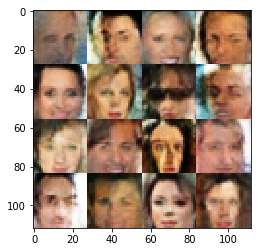

Epoch 0/1... Discriminator Loss: 0.8915... Generator Loss: 1.5070
Epoch 0/1... Discriminator Loss: 1.2196... Generator Loss: 0.7241
Epoch 0/1... Discriminator Loss: 1.2638... Generator Loss: 0.7679
Epoch 0/1... Discriminator Loss: 1.0757... Generator Loss: 0.8461
Epoch 0/1... Discriminator Loss: 1.2947... Generator Loss: 0.7585


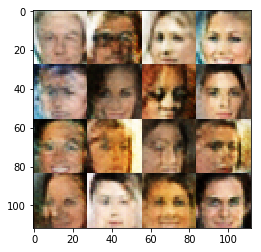

Epoch 0/1... Discriminator Loss: 0.8195... Generator Loss: 1.5873
Epoch 0/1... Discriminator Loss: 1.3465... Generator Loss: 1.1797
Epoch 0/1... Discriminator Loss: 1.3253... Generator Loss: 0.5703
Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 0.8430
Epoch 0/1... Discriminator Loss: 1.5864... Generator Loss: 0.4323


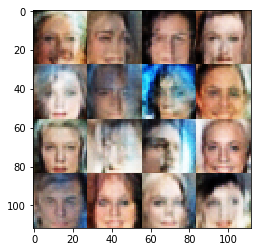

Epoch 0/1... Discriminator Loss: 1.2687... Generator Loss: 0.7542
Epoch 0/1... Discriminator Loss: 1.2475... Generator Loss: 0.8669
Epoch 0/1... Discriminator Loss: 1.4213... Generator Loss: 0.8916
Epoch 0/1... Discriminator Loss: 1.4233... Generator Loss: 0.6492
Epoch 0/1... Discriminator Loss: 1.3554... Generator Loss: 0.8463


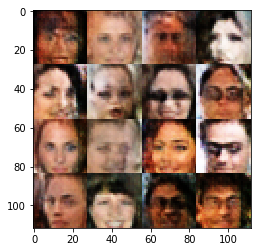

Epoch 0/1... Discriminator Loss: 1.2417... Generator Loss: 0.7510
Epoch 0/1... Discriminator Loss: 1.0238... Generator Loss: 0.9704
Epoch 0/1... Discriminator Loss: 1.3169... Generator Loss: 0.7567
Epoch 0/1... Discriminator Loss: 1.1914... Generator Loss: 0.8864
Epoch 0/1... Discriminator Loss: 1.1730... Generator Loss: 0.8238


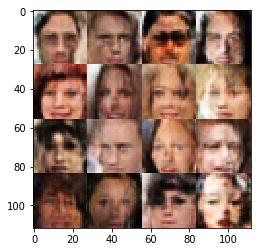

Epoch 0/1... Discriminator Loss: 1.1077... Generator Loss: 1.1441
Epoch 0/1... Discriminator Loss: 1.1903... Generator Loss: 0.9481
Epoch 0/1... Discriminator Loss: 1.2680... Generator Loss: 1.2273
Epoch 0/1... Discriminator Loss: 1.2742... Generator Loss: 0.8580
Epoch 0/1... Discriminator Loss: 1.0088... Generator Loss: 1.0239


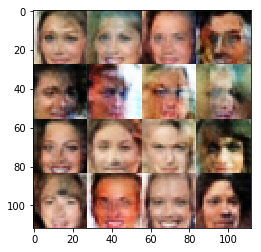

Epoch 0/1... Discriminator Loss: 1.1876... Generator Loss: 0.8784
Epoch 0/1... Discriminator Loss: 1.5224... Generator Loss: 0.4309
Epoch 0/1... Discriminator Loss: 1.1594... Generator Loss: 0.8235
Epoch 0/1... Discriminator Loss: 1.1729... Generator Loss: 0.9607
Epoch 0/1... Discriminator Loss: 1.1681... Generator Loss: 0.8770


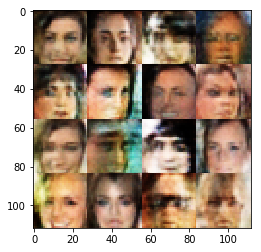

Epoch 0/1... Discriminator Loss: 1.2876... Generator Loss: 0.8388
Epoch 0/1... Discriminator Loss: 1.0989... Generator Loss: 1.0055
Epoch 0/1... Discriminator Loss: 1.1087... Generator Loss: 1.1095
Epoch 0/1... Discriminator Loss: 1.2059... Generator Loss: 0.7733
Epoch 0/1... Discriminator Loss: 1.1649... Generator Loss: 0.8751


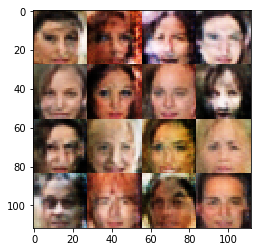

Epoch 0/1... Discriminator Loss: 1.3962... Generator Loss: 0.6272
Epoch 0/1... Discriminator Loss: 1.3603... Generator Loss: 0.8278
Epoch 0/1... Discriminator Loss: 1.2491... Generator Loss: 0.6893
Epoch 0/1... Discriminator Loss: 1.1510... Generator Loss: 1.0292
Epoch 0/1... Discriminator Loss: 1.1558... Generator Loss: 0.9118


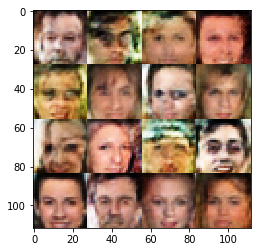

Epoch 0/1... Discriminator Loss: 1.3562... Generator Loss: 0.6044
Epoch 0/1... Discriminator Loss: 1.2287... Generator Loss: 0.7974
Epoch 0/1... Discriminator Loss: 1.1251... Generator Loss: 0.9213
Epoch 0/1... Discriminator Loss: 1.4155... Generator Loss: 0.6308
Epoch 0/1... Discriminator Loss: 1.3223... Generator Loss: 0.6508


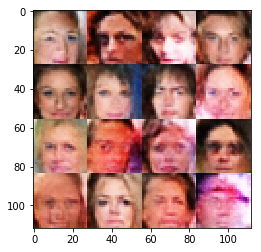

Epoch 0/1... Discriminator Loss: 1.1148... Generator Loss: 0.8943
Epoch 0/1... Discriminator Loss: 0.9841... Generator Loss: 1.1456
Epoch 0/1... Discriminator Loss: 1.2954... Generator Loss: 0.6514
Epoch 0/1... Discriminator Loss: 1.2607... Generator Loss: 0.7576
Epoch 0/1... Discriminator Loss: 1.1036... Generator Loss: 1.1753


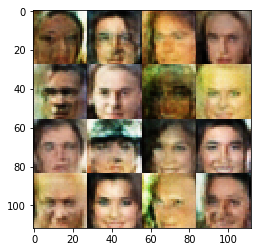

Epoch 0/1... Discriminator Loss: 0.8982... Generator Loss: 1.3690
Epoch 0/1... Discriminator Loss: 1.1366... Generator Loss: 1.0987
Epoch 0/1... Discriminator Loss: 1.6252... Generator Loss: 0.4568
Epoch 0/1... Discriminator Loss: 1.3669... Generator Loss: 0.6863
Epoch 0/1... Discriminator Loss: 1.1525... Generator Loss: 0.7653


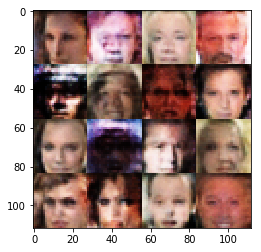

Epoch 0/1... Discriminator Loss: 1.1036... Generator Loss: 0.8620
Epoch 0/1... Discriminator Loss: 1.1528... Generator Loss: 0.8988
Epoch 0/1... Discriminator Loss: 1.2099... Generator Loss: 0.9426
Epoch 0/1... Discriminator Loss: 1.1282... Generator Loss: 0.9843
Epoch 0/1... Discriminator Loss: 1.2493... Generator Loss: 0.8052


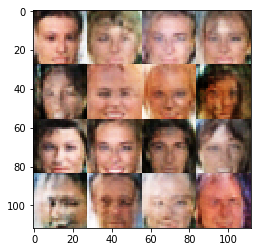

Epoch 0/1... Discriminator Loss: 1.1725... Generator Loss: 1.0084
Epoch 0/1... Discriminator Loss: 1.2368... Generator Loss: 0.8430
Epoch 0/1... Discriminator Loss: 1.0150... Generator Loss: 0.9855
Epoch 0/1... Discriminator Loss: 1.5042... Generator Loss: 0.5125
Epoch 0/1... Discriminator Loss: 1.2312... Generator Loss: 0.7453


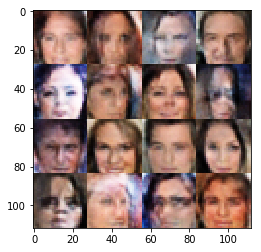

Epoch 0/1... Discriminator Loss: 1.3022... Generator Loss: 0.8452
Epoch 0/1... Discriminator Loss: 1.2830... Generator Loss: 0.6249
Epoch 0/1... Discriminator Loss: 1.2628... Generator Loss: 0.7012
Epoch 0/1... Discriminator Loss: 1.2999... Generator Loss: 0.6994
Epoch 0/1... Discriminator Loss: 1.2742... Generator Loss: 0.6636


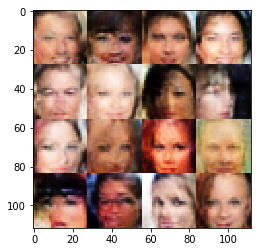

Epoch 0/1... Discriminator Loss: 1.2617... Generator Loss: 0.8527
Epoch 0/1... Discriminator Loss: 1.6397... Generator Loss: 0.3842
Epoch 0/1... Discriminator Loss: 1.2888... Generator Loss: 0.7634
Epoch 0/1... Discriminator Loss: 1.3303... Generator Loss: 0.6583
Epoch 0/1... Discriminator Loss: 1.2308... Generator Loss: 0.8310


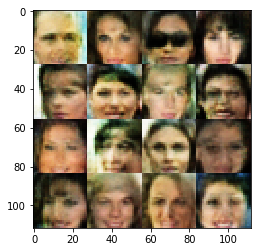

Epoch 0/1... Discriminator Loss: 1.0588... Generator Loss: 1.1857
Epoch 0/1... Discriminator Loss: 1.0733... Generator Loss: 1.0537
Epoch 0/1... Discriminator Loss: 1.5467... Generator Loss: 0.4140
Epoch 0/1... Discriminator Loss: 1.3549... Generator Loss: 0.6246
Epoch 0/1... Discriminator Loss: 1.1547... Generator Loss: 0.9215


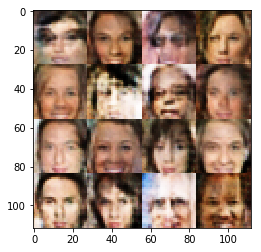

Epoch 0/1... Discriminator Loss: 1.0801... Generator Loss: 1.1945
Epoch 0/1... Discriminator Loss: 1.2087... Generator Loss: 0.8774
Epoch 0/1... Discriminator Loss: 1.1781... Generator Loss: 0.9085
Epoch 0/1... Discriminator Loss: 1.4045... Generator Loss: 0.5061
Epoch 0/1... Discriminator Loss: 1.2826... Generator Loss: 0.6709


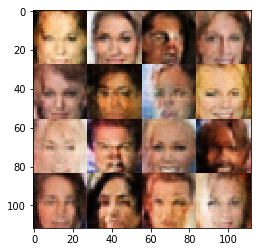

Epoch 0/1... Discriminator Loss: 0.9551... Generator Loss: 1.0722
Epoch 0/1... Discriminator Loss: 1.2926... Generator Loss: 0.9150
Epoch 0/1... Discriminator Loss: 1.2928... Generator Loss: 0.7984
Epoch 0/1... Discriminator Loss: 1.2294... Generator Loss: 0.7439
Epoch 0/1... Discriminator Loss: 1.5028... Generator Loss: 0.7901


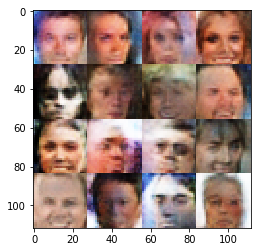

Epoch 0/1... Discriminator Loss: 1.2132... Generator Loss: 0.8978
Epoch 0/1... Discriminator Loss: 1.1653... Generator Loss: 0.8238
Epoch 0/1... Discriminator Loss: 1.1982... Generator Loss: 1.0244
Epoch 0/1... Discriminator Loss: 1.4319... Generator Loss: 0.5348
Epoch 0/1... Discriminator Loss: 1.3503... Generator Loss: 0.7027


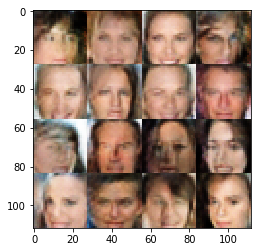

Epoch 0/1... Discriminator Loss: 1.1639... Generator Loss: 0.8954
Epoch 0/1... Discriminator Loss: 1.1001... Generator Loss: 0.8830
Epoch 0/1... Discriminator Loss: 1.4381... Generator Loss: 0.5189
Epoch 0/1... Discriminator Loss: 1.5021... Generator Loss: 0.4565
Epoch 0/1... Discriminator Loss: 1.2232... Generator Loss: 1.1724


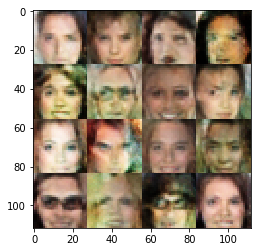

Epoch 0/1... Discriminator Loss: 1.4933... Generator Loss: 0.6115
Epoch 0/1... Discriminator Loss: 1.3687... Generator Loss: 0.6175
Epoch 0/1... Discriminator Loss: 0.9953... Generator Loss: 1.1979
Epoch 0/1... Discriminator Loss: 1.2439... Generator Loss: 0.8109
Epoch 0/1... Discriminator Loss: 1.2619... Generator Loss: 0.7924


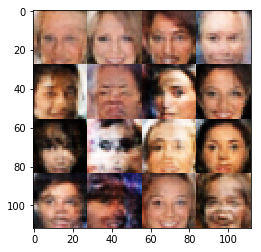

Epoch 0/1... Discriminator Loss: 1.3618... Generator Loss: 0.6132
Epoch 0/1... Discriminator Loss: 1.0841... Generator Loss: 1.0129
Epoch 0/1... Discriminator Loss: 1.2372... Generator Loss: 0.8139
Epoch 0/1... Discriminator Loss: 1.1832... Generator Loss: 1.0866
Epoch 0/1... Discriminator Loss: 1.2017... Generator Loss: 0.7723


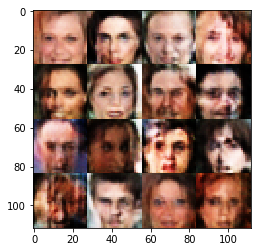

Epoch 0/1... Discriminator Loss: 1.1794... Generator Loss: 0.9045
Epoch 0/1... Discriminator Loss: 1.2221... Generator Loss: 0.9832
Epoch 0/1... Discriminator Loss: 1.2786... Generator Loss: 0.6953
Epoch 0/1... Discriminator Loss: 1.2201... Generator Loss: 0.7254
Epoch 0/1... Discriminator Loss: 1.2923... Generator Loss: 0.7586


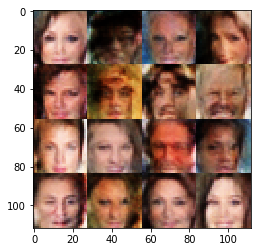

Epoch 0/1... Discriminator Loss: 1.1079... Generator Loss: 1.4295
Epoch 0/1... Discriminator Loss: 1.1741... Generator Loss: 0.7988
Epoch 0/1... Discriminator Loss: 1.2699... Generator Loss: 1.4807
Epoch 0/1... Discriminator Loss: 1.2216... Generator Loss: 0.9201
Epoch 0/1... Discriminator Loss: 1.0993... Generator Loss: 0.9509


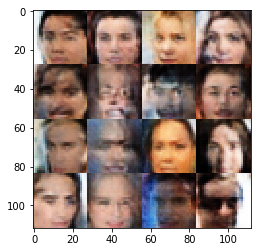

Epoch 0/1... Discriminator Loss: 1.2526... Generator Loss: 0.8179
Epoch 0/1... Discriminator Loss: 1.1861... Generator Loss: 0.8477
Epoch 0/1... Discriminator Loss: 1.1352... Generator Loss: 1.0900
Epoch 0/1... Discriminator Loss: 1.0563... Generator Loss: 1.0169
Epoch 0/1... Discriminator Loss: 1.2498... Generator Loss: 1.0375


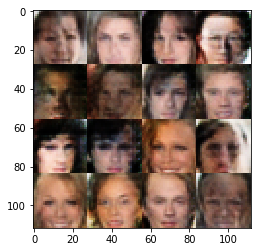

Epoch 0/1... Discriminator Loss: 1.1822... Generator Loss: 0.6638
Epoch 0/1... Discriminator Loss: 1.3938... Generator Loss: 0.5266
Epoch 0/1... Discriminator Loss: 1.3432... Generator Loss: 0.6442
Epoch 0/1... Discriminator Loss: 1.4243... Generator Loss: 0.5040
Epoch 0/1... Discriminator Loss: 1.3287... Generator Loss: 0.5702


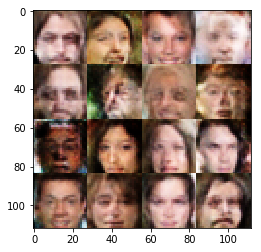

Epoch 0/1... Discriminator Loss: 1.1281... Generator Loss: 0.8270
Epoch 0/1... Discriminator Loss: 1.2983... Generator Loss: 0.6538
Epoch 0/1... Discriminator Loss: 1.2854... Generator Loss: 0.7037
Epoch 0/1... Discriminator Loss: 1.1148... Generator Loss: 1.0225
Epoch 0/1... Discriminator Loss: 1.2995... Generator Loss: 0.6804


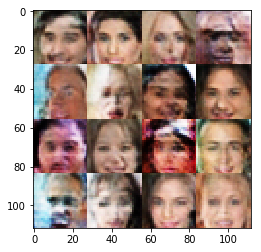

Epoch 0/1... Discriminator Loss: 0.9329... Generator Loss: 1.1061
Epoch 0/1... Discriminator Loss: 1.3337... Generator Loss: 0.6140
Epoch 0/1... Discriminator Loss: 1.1182... Generator Loss: 0.9050
Epoch 0/1... Discriminator Loss: 0.9160... Generator Loss: 1.0185
Epoch 0/1... Discriminator Loss: 1.7238... Generator Loss: 0.5442


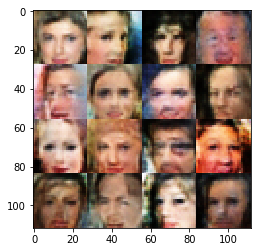

Epoch 0/1... Discriminator Loss: 1.4027... Generator Loss: 0.7249
Epoch 0/1... Discriminator Loss: 1.3746... Generator Loss: 0.7221
Epoch 0/1... Discriminator Loss: 1.6216... Generator Loss: 0.4564
Epoch 0/1... Discriminator Loss: 1.3461... Generator Loss: 0.8339
Epoch 0/1... Discriminator Loss: 1.3675... Generator Loss: 0.5204


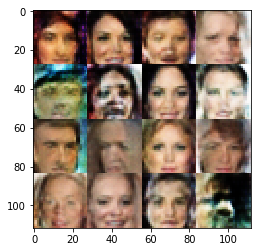

Epoch 0/1... Discriminator Loss: 1.4212... Generator Loss: 0.6109
Epoch 0/1... Discriminator Loss: 1.1084... Generator Loss: 1.0157
Epoch 0/1... Discriminator Loss: 1.1695... Generator Loss: 0.9833
Epoch 0/1... Discriminator Loss: 1.3843... Generator Loss: 0.7035
Epoch 0/1... Discriminator Loss: 1.4551... Generator Loss: 0.7103


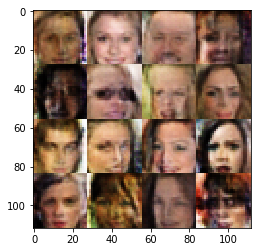

Epoch 0/1... Discriminator Loss: 1.4447... Generator Loss: 0.7284
Epoch 0/1... Discriminator Loss: 1.3358... Generator Loss: 0.6060
Epoch 0/1... Discriminator Loss: 1.2381... Generator Loss: 0.7963
Epoch 0/1... Discriminator Loss: 1.1188... Generator Loss: 0.8620
Epoch 0/1... Discriminator Loss: 1.3603... Generator Loss: 0.5963


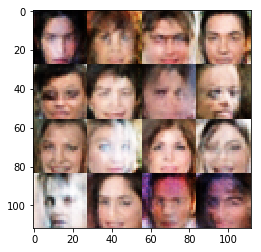

Epoch 0/1... Discriminator Loss: 1.1096... Generator Loss: 1.0753
Epoch 0/1... Discriminator Loss: 1.3078... Generator Loss: 0.7810
Epoch 0/1... Discriminator Loss: 1.3674... Generator Loss: 0.7320
Epoch 0/1... Discriminator Loss: 1.0696... Generator Loss: 0.9724
Epoch 0/1... Discriminator Loss: 1.3059... Generator Loss: 0.6999


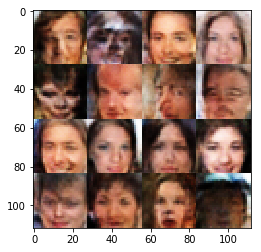

Epoch 0/1... Discriminator Loss: 1.1374... Generator Loss: 0.8973
Epoch 0/1... Discriminator Loss: 1.2813... Generator Loss: 0.8637
Epoch 0/1... Discriminator Loss: 1.3539... Generator Loss: 0.6753
Epoch 0/1... Discriminator Loss: 1.2678... Generator Loss: 0.6686
Epoch 0/1... Discriminator Loss: 1.1062... Generator Loss: 0.7627


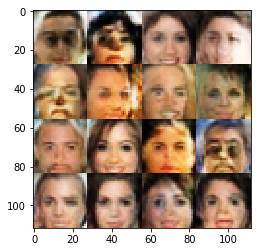

Epoch 0/1... Discriminator Loss: 1.2243... Generator Loss: 0.7471
Epoch 0/1... Discriminator Loss: 1.3864... Generator Loss: 0.7177
Epoch 0/1... Discriminator Loss: 1.1160... Generator Loss: 0.9593
Epoch 0/1... Discriminator Loss: 1.1972... Generator Loss: 0.6548
Epoch 0/1... Discriminator Loss: 1.2389... Generator Loss: 0.7502


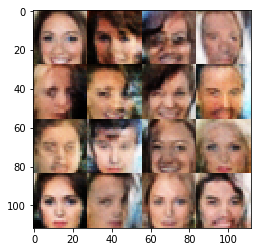

Epoch 0/1... Discriminator Loss: 1.3564... Generator Loss: 0.7110
Epoch 0/1... Discriminator Loss: 1.2599... Generator Loss: 0.9236
Epoch 0/1... Discriminator Loss: 1.2592... Generator Loss: 0.7885
Epoch 0/1... Discriminator Loss: 1.3589... Generator Loss: 0.6197
Epoch 0/1... Discriminator Loss: 1.1610... Generator Loss: 0.8646


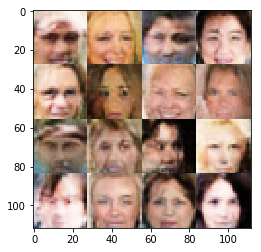

Epoch 0/1... Discriminator Loss: 1.2471... Generator Loss: 0.7231
Epoch 0/1... Discriminator Loss: 1.1475... Generator Loss: 1.0998
Epoch 0/1... Discriminator Loss: 1.4241... Generator Loss: 0.5447
Epoch 0/1... Discriminator Loss: 1.2065... Generator Loss: 0.7187
Epoch 0/1... Discriminator Loss: 1.3473... Generator Loss: 0.6165


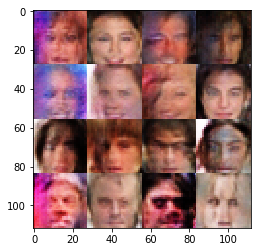

Epoch 0/1... Discriminator Loss: 1.2935... Generator Loss: 0.6373
Epoch 0/1... Discriminator Loss: 0.8492... Generator Loss: 1.1675
Epoch 0/1... Discriminator Loss: 1.5189... Generator Loss: 0.4714
Epoch 0/1... Discriminator Loss: 1.1258... Generator Loss: 1.1851
Epoch 0/1... Discriminator Loss: 1.1354... Generator Loss: 1.0101


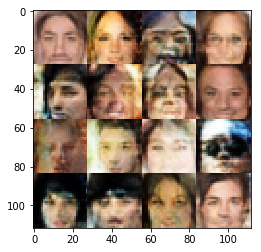

Epoch 0/1... Discriminator Loss: 1.1944... Generator Loss: 0.9464
Epoch 0/1... Discriminator Loss: 1.3804... Generator Loss: 0.7651
Epoch 0/1... Discriminator Loss: 1.1934... Generator Loss: 0.8687
Epoch 0/1... Discriminator Loss: 1.1545... Generator Loss: 0.9035
Epoch 0/1... Discriminator Loss: 1.3760... Generator Loss: 0.5828


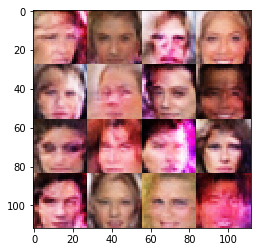

Epoch 0/1... Discriminator Loss: 1.3690... Generator Loss: 0.6807
Epoch 0/1... Discriminator Loss: 1.2883... Generator Loss: 0.7201
Epoch 0/1... Discriminator Loss: 1.4371... Generator Loss: 0.8275
Epoch 0/1... Discriminator Loss: 1.1620... Generator Loss: 0.8097
Epoch 0/1... Discriminator Loss: 1.2131... Generator Loss: 0.8841


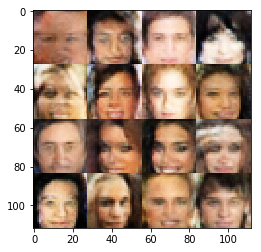

Epoch 0/1... Discriminator Loss: 1.4802... Generator Loss: 0.6048
Epoch 0/1... Discriminator Loss: 1.4945... Generator Loss: 0.5250
Epoch 0/1... Discriminator Loss: 1.1220... Generator Loss: 0.8309
Epoch 0/1... Discriminator Loss: 1.4219... Generator Loss: 0.5409
Epoch 0/1... Discriminator Loss: 1.2354... Generator Loss: 0.7995


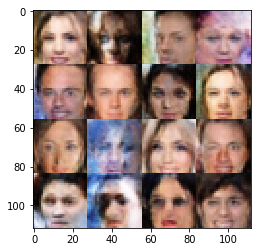

Epoch 0/1... Discriminator Loss: 1.1482... Generator Loss: 1.0254
Epoch 0/1... Discriminator Loss: 1.2261... Generator Loss: 0.8183
Epoch 0/1... Discriminator Loss: 1.0720... Generator Loss: 0.7476
Epoch 0/1... Discriminator Loss: 1.4231... Generator Loss: 0.5064
Epoch 0/1... Discriminator Loss: 1.4163... Generator Loss: 0.8003


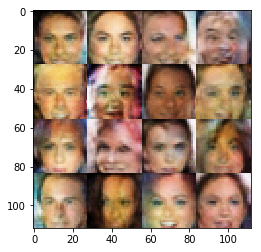

Epoch 0/1... Discriminator Loss: 1.2680... Generator Loss: 0.7666
Epoch 0/1... Discriminator Loss: 1.0318... Generator Loss: 0.8676
Epoch 0/1... Discriminator Loss: 1.1662... Generator Loss: 0.8237
Epoch 0/1... Discriminator Loss: 1.2473... Generator Loss: 0.7829
Epoch 0/1... Discriminator Loss: 1.3593... Generator Loss: 0.5260


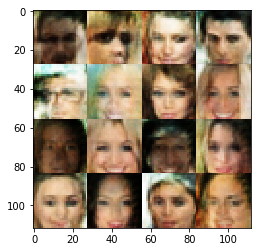

Epoch 0/1... Discriminator Loss: 1.2941... Generator Loss: 0.7578
Epoch 0/1... Discriminator Loss: 1.3027... Generator Loss: 0.6344
Epoch 0/1... Discriminator Loss: 1.2830... Generator Loss: 0.7330
Epoch 0/1... Discriminator Loss: 1.5552... Generator Loss: 0.4385
Epoch 0/1... Discriminator Loss: 1.2666... Generator Loss: 0.7868


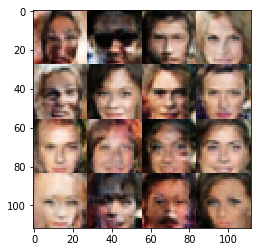

Epoch 0/1... Discriminator Loss: 1.1354... Generator Loss: 0.8481
Epoch 0/1... Discriminator Loss: 1.1400... Generator Loss: 0.9491
Epoch 0/1... Discriminator Loss: 1.2050... Generator Loss: 0.8145
Epoch 0/1... Discriminator Loss: 1.3325... Generator Loss: 0.7598
Epoch 0/1... Discriminator Loss: 1.3097... Generator Loss: 0.7599


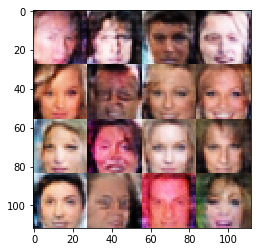

Epoch 0/1... Discriminator Loss: 1.3115... Generator Loss: 0.6596
Epoch 0/1... Discriminator Loss: 1.2757... Generator Loss: 0.9097
Epoch 0/1... Discriminator Loss: 1.3330... Generator Loss: 0.8631
Epoch 0/1... Discriminator Loss: 1.3739... Generator Loss: 0.6217
Epoch 0/1... Discriminator Loss: 1.3078... Generator Loss: 0.8268


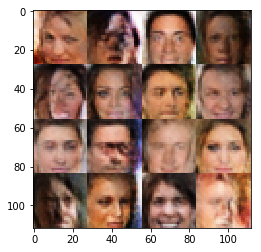

Epoch 0/1... Discriminator Loss: 1.2735... Generator Loss: 0.8017
Epoch 0/1... Discriminator Loss: 1.2700... Generator Loss: 0.7759
Epoch 0/1... Discriminator Loss: 1.1891... Generator Loss: 0.8662
Epoch 0/1... Discriminator Loss: 0.8890... Generator Loss: 1.3682
Epoch 0/1... Discriminator Loss: 1.5700... Generator Loss: 0.6057


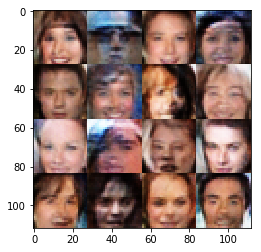

Epoch 0/1... Discriminator Loss: 1.2626... Generator Loss: 0.7477
Epoch 0/1... Discriminator Loss: 1.0272... Generator Loss: 1.1457
Epoch 0/1... Discriminator Loss: 1.3133... Generator Loss: 0.6637
Epoch 0/1... Discriminator Loss: 1.0678... Generator Loss: 1.1836
Epoch 0/1... Discriminator Loss: 1.2908... Generator Loss: 0.7999


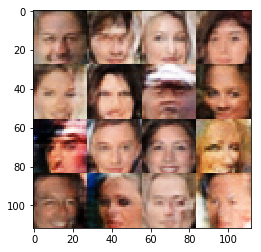

Epoch 0/1... Discriminator Loss: 1.2597... Generator Loss: 0.7997
Epoch 0/1... Discriminator Loss: 1.3911... Generator Loss: 0.5617
Epoch 0/1... Discriminator Loss: 1.0794... Generator Loss: 0.8502
Epoch 0/1... Discriminator Loss: 1.2493... Generator Loss: 0.8589


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。